# **1- Import des bibliothèques nécessaires, Chargement et Aperçu des Données**

## **1.1 Import des bibliothèques nécessaires et Chargement des données**

In [3]:
#Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib


#Chargement du dataset Hotel_Booking_Demand 
hotel_df = pd.read_csv("data/hotel_bookings.csv")

## **1.2 Aperçu des données**

In [5]:
#Aperçu des données
hotel_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# **2- Nettoyage des données**

## **2.1 Gestion et Traitement des valeurs manquantes** 

### **2.1.1 Détection des valeurs manquantes**

In [9]:
#Informations sur le dataset
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
#Sommes des valeurs manquantes 
missing_values = hotel_df.isnull().sum()

for c in hotel_df: 
    if hotel_df[c].count() < 119390: 
        print('La colonne',c,'a',missing_values[c],'valeurs manquantes sur 119390, soit:',round((missing_values[c]/119390*100),3),'%')

La colonne children a 4 valeurs manquantes sur 119390, soit: 0.003 %
La colonne country a 488 valeurs manquantes sur 119390, soit: 0.409 %
La colonne agent a 16340 valeurs manquantes sur 119390, soit: 13.686 %
La colonne company a 112593 valeurs manquantes sur 119390, soit: 94.307 %


**Analyse des valeurs manquantes :**

Identifier les colonnes concernées :

|Colonne|Pourcentages de valeurs manquantes| Type de donnée | Importance |
|:-------|:-------|:-------|:-------|
|children| \~0.003 % de valeurs manquantes|Numérique (nombre d'enfants)|Élevée (impacte la capacité de l’hôtel)|
|country| \~0.41 % de valeurs manquantes|Catégorielle (code pays)|Moyenne (utile pour l’analyse des clients)|
|agent: |\~13.87 % de valeurs manquantes|Numérique (ID de l’agent de réservation)|Moyenne (peut être utile pour comprendre les canaux de réservation)|
|company| \~94.3 % de valeurs manquantes|Numérique (ID de la société)|Faible (très peu de valeurs renseignées)|

**Plan d'action pour chaque colonne:**  
      
1. **Colonne children (0.003 % de valeurs manquantes)**  
   ***Action recommandée :*** Imputation par 0.
   Il est probable que l'absence de valeur signifie simplement "pas d'enfants".  
  
3. **Colonne country (0.41 % de valeurs manquantes)**  
   ***Action recommandée :*** Imputation par le pays le plus fréquent.
   Ces valeurs sont essentielles pour les analyses de provenances des clients.  
  
3. **Colonne agent (13.87 % de valeurs manquantes)**  
   ***Action recommandée :*** Imputation par 0 *(pour garder la colonne comme variable numérique)* une nouvelle catégorie "Sans agent". Cependant, afin de garder cette variable comme variable numérique, ***nous imputerons 0.***
   Un NaN dans cette colonne signifie probablement "aucun agent utilisé" (réservation directe).  
  
5. **Colonne company (94.3 % de valeurs manquantes)**  
   ***Action recommandée :*** Suppression ou création d'une nouvelle variable "has_company".
   Cette colonne a trop de valeurs manquantes. Étant donné la faible importance de cette colonne, ***nous pouvons la supprimer***. 


### **2.1.2 Traitement des valeurs manquantes pour children**

In [13]:
# Remplacer les valeurs manquantes de la colonne children par 0
hotel_df.fillna({'children': 0}, inplace=True)

#Verification
print('Nombre de valeurs manquantes de la colonne children après traitement :', hotel_df['children'].isnull().sum())

Nombre de valeurs manquantes de la colonne children après traitement : 0


### **2.1.3 Traitement des valeurs manquantes pour country**

In [15]:
#Vérifier le mode de la colonne country (valeur la plus fréquente) 
mode_country = hotel_df['country'].mode()[0]
print('Le mode de la colonne country est :', mode_country)

#Remplacer les valeurs manquantes de la colonne country par mode_country
hotel_df.fillna({'country': mode_country}, inplace=True)

#Vérification
print('Nombre de valeurs manquantes de la colonne country après traitement:', hotel_df['country'].isnull().sum())

Le mode de la colonne country est : PRT
Nombre de valeurs manquantes de la colonne country après traitement: 0


### **2.1.4 Traitement des valeurs manquantes pour agent**

In [17]:
# Remplacer les valeurs manquantes de la colonne agent par 0
hotel_df.fillna({'agent': 0}, inplace=True)

#Verification
print('Nombre de valeurs manquantes de la colonne agent après traitement :', hotel_df['agent'].isnull().sum())

Nombre de valeurs manquantes de la colonne agent après traitement : 0


### **2.1.5 Traitement des valeurs manquantes pour company**

In [19]:
#Supression de la colonne company
hotel_df.drop(columns=['company'], inplace=True)

#Verification
print('company' in hotel_df.columns)  # Doit afficher False

False


### **2.1.6 Vérification finale des valeurs manquantes**

In [21]:
#Sommes des valeurs manquantes après traitement 
missing_values_final = hotel_df.isnull().sum()
print("Valeurs manquantes restantes :")
print(missing_values_final[missing_values_final > 0])

Valeurs manquantes restantes :
Series([], dtype: int64)


# **3- Vérification et correction des types de données**

## **3.1 Identification et Détection des types de données**

In [24]:
#Identifier les types de données par colonnes
print(hotel_df.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

 **Détection des types de données à corriger**

- arrival_date_year, arrival_date_month, arrival_date_day_of_month → doivent pouvoir être traités ensemble ***(Compilation et mise au format datetime)***
- reservation_status_date → object ***(devrait être en format datetime)***
- children → float64 ***(devrait être int, pas de demi-enfant !)***

## **3.2 Conversion des types de données à corriger et Vérification**

In [27]:
#Compilation de arrival_date_year, arrival_date_month, arrival_date_day_of_month et mise au format datetime
hotel_df['arrival_datetime'] = pd.to_datetime(hotel_df['arrival_date_year'].astype(str) + '-' +
                                              hotel_df['arrival_date_month'].astype(str) + '-' +
                                              hotel_df['arrival_date_day_of_month'].astype(str), 
                                              format='%Y-%B-%d')

# Convertir reservation_status_date en datetime
hotel_df['reservation_status_date'] = pd.to_datetime(hotel_df['reservation_status_date'], errors='coerce')

# Convertir children en int
hotel_df['children'] = hotel_df['children'].astype('int64')

## **3.3 Vérification des conversions effectuées**

In [29]:
#Verification des modifications effectuées
print(hotel_df[['reservation_status_date', 'children', 'arrival_datetime']].dtypes)

reservation_status_date    datetime64[ns]
children                            int64
arrival_datetime           datetime64[ns]
dtype: object


# **4- Exploratory Data Analysis**

## **4.1 Identification des Variables Numériques Significatives**

### **4.1.1 Identification des variables numériques significatives (corrélation Pearson)**

.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Coefficient de corrélation de Pearson des variables numériques

Corrélations de Pearson entre is_canceled et les variables numériques :



,is_canceled
lead_time,0.293123
previous_cancellations,0.110133
adults,0.060017
days_in_waiting_list,0.054186
adr,0.047557
stays_in_week_nights,0.024765
arrival_date_year,0.016660
arrival_date_week_number,0.008148
children,0.005036
stays_in_weekend_nights,-0.001791


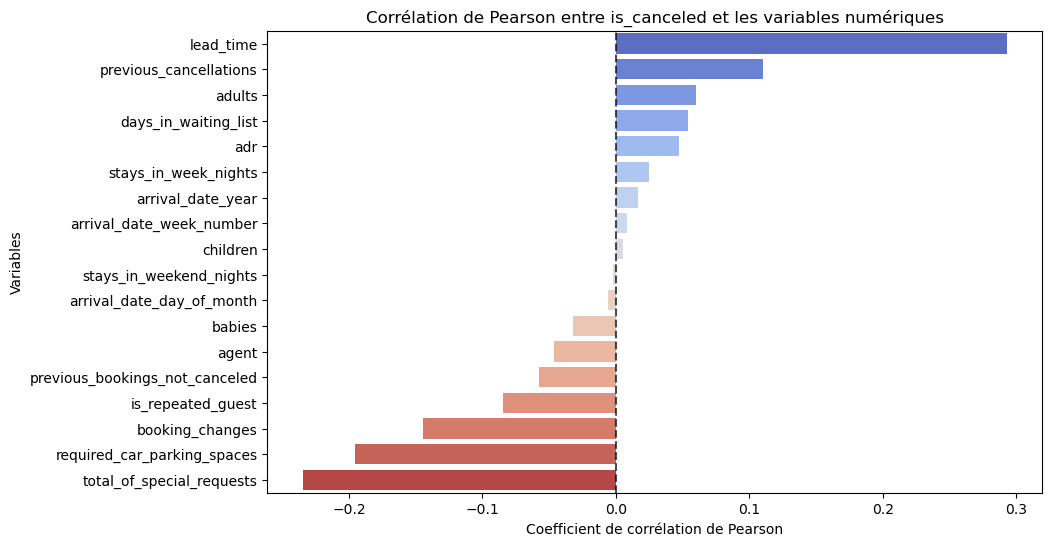

In [34]:
# Filtrer uniquement les colonnes numériques
numeric_cols = hotel_df.select_dtypes(include=['int64', 'float64'])

# Calcul des corrélations de Pearson entre les variables numériques et is_canceled
correlation_matrix = numeric_cols.corr()

# Sélection des corrélations avec is_canceled uniquement
correlation_with_target = correlation_matrix["is_canceled"].drop("is_canceled").sort_values(ascending=False)

# Affichage des corrélations sous forme de tableau
print("Corrélations de Pearson entre is_canceled et les variables numériques :\n")
display(correlation_with_target.to_frame())

# Visualisation sous forme de barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, hue=correlation_with_target.index, palette="coolwarm")
plt.title("Corrélation de Pearson entre is_canceled et les variables numériques")
plt.xlabel("Coefficient de corrélation de Pearson")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle="--", alpha=0.7)  # Ligne verticale pour séparer valeurs positives et négatives
plt.show()


  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse du tableau de Corrélation (Pearson) entre is_canceled et les variables numériques

**Pourquoi cette analyse ?**  
Le **tableau de corrélation Pearson** permet d'identifier **les relations entre les variables numériques** et `is_canceled`.  
L’objectif est d’identifier les variables les plus influentes sur les annulations.


**Seuil de significativité**
- **Corrélation > |0,1|** *(valeurs absolues)* **: La variable est significative.**

**Conclusion :**

| Variable | Corrélation avec is_canceled | À vérifier |
|----------|-------------------------------|----------------|
| lead_time | **+0.293** | 	Distribution possiblement asymétrique → Vérifier un log-transform. |
| previous_cancellations | **+0.110** | Vérifier la répartition (beaucoup de 0 ?). |
| booking_changes | **-0.144** | Vérifier si la distribution est équilibrée.|
| required_car_parking_spaces | **-0.195** | Vérifier la proportion de 0. |
| total_of_special_requests | **-0.234** | Vérifier si c’est bien une variable discrète ou si certaines valeurs sont rares. |


L’analyse de Pearson nous a permis d’identifier les variables numériques ayant une corrélation significative avec `is_canceled`, mais elle ne renseigne pas sur les interactions entre ces variables.

**Pourquoi une heatmap après Pearson ?**
L’étape suivante consiste à analyser les relations entre ces variables elles-mêmes afin de :
1. **Vérifier la colinéarité**  
   - Si deux variables sont fortement corrélées, l’une peut être supprimée sans perte d’information.
2. **Confirmer l’indépendance des variables**  
   - Une variable peut sembler liée à is_canceled, mais uniquement via une autre variable plus influente.
     C'est-à-dire qu'une variable pourrait paraître importante pour `is_canceled`, mais en réalité, elle ne fait que refléter l’effet d’une autre variable.
3. **Optimiser le preprocessing**  
   - Sélectionner les variables apportant une information unique et éviter la colinéarité dans le modèle. 
  
**La heatmap permet donc d’optimiser le choix des variables en identifiant celles qui apportent une information unique.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Heatmap de corrélation des variables numériques significatives

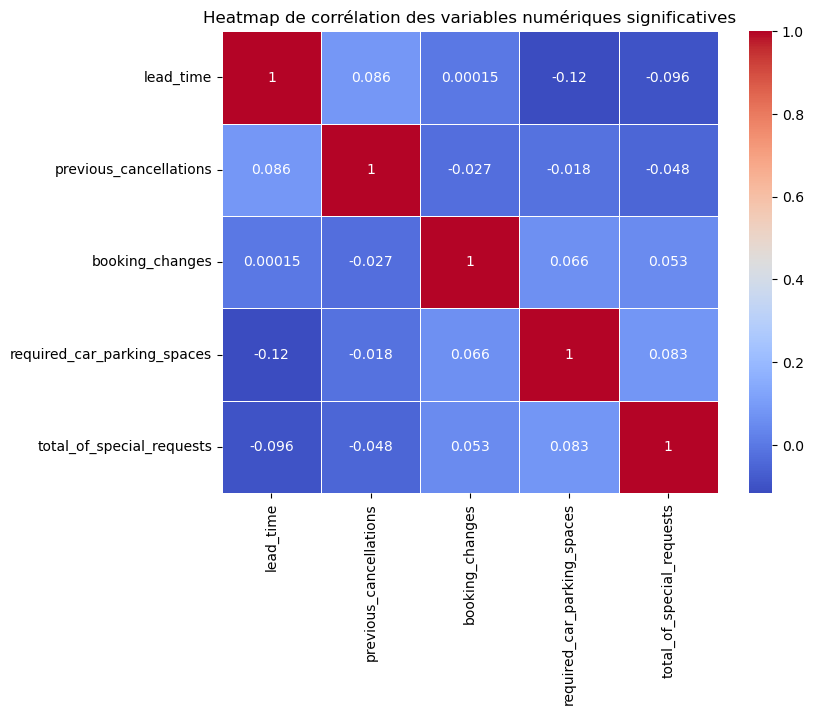

In [37]:
# Filtrer uniquement les colonnes numériques significatives
significativ_numeric_cols = hotel_df[['lead_time', 'previous_cancellations', 'booking_changes',
                                      'required_car_parking_spaces','total_of_special_requests']]

# Calcul de la matrice de corrélation
plt.figure(figsize=(8,6))
sns.heatmap(significativ_numeric_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap de corrélation des variables numériques significatives")
plt.show()

  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse de la Matrice de Corrélation (Heatmap) des variables numériques significatives

**Pourquoi cette analyse ?**  
Après la sélection des variables numériques significatives via le test de Pearson, cette heatmap permet d’identifier d’éventuelles relations fortes entre ces variables.  
L’objectif est de **détecter d’éventuelles colinéarités** qui pourraient fausser le modèle ou rendre certaines variables redondantes.  

**Seuils de colinéarité**  
La colinéarité est généralement évaluée selon ces seuils :  
- **|r| < 0.3** → Faible corrélation (aucun problème de colinéarité).  
- **0.3 ≤ |r| < 0.7** → Corrélation modérée (potentiellement préoccupant selon le contexte).  
- **|r| ≥ 0.7** → Corrélation forte (peut entraîner des problèmes de redondance dans le modèle).  

Un seuil de **0.7 ou 0.8** est généralement utilisé pour détecter des variables fortement colinéaires.  

**Résultats et interprétation**  
- **Aucune corrélation forte n’est détectée** entre les variables sélectionnées.  
- Les valeurs les plus élevées sont :  
  - `lead_time` ↔ `required_car_parking_spaces` (**-0.12**)  
  - `previous_cancellations` ↔ `lead_time` (**0.086**)  
- Ces corrélations restent très faibles et **aucune variable ne semble redondante**.  

**Conclusion**  
**Aucune variable ne doit être supprimée pour cause de colinéarité.**  
Les variables conservent chacune une information unique et peuvent être utilisées dans le modèle sans risque de redondance.  
La prochaine étape consistera à **examiner la distribution des variables** pour voir si des transformations sont nécessaires avant le preprocessing.  

### **4.1.2 Analyse des distributions et des valeurs extrêmes et prise de décision sur les transformations à effectuer**

.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Distribution des variables numériques singnificatives 

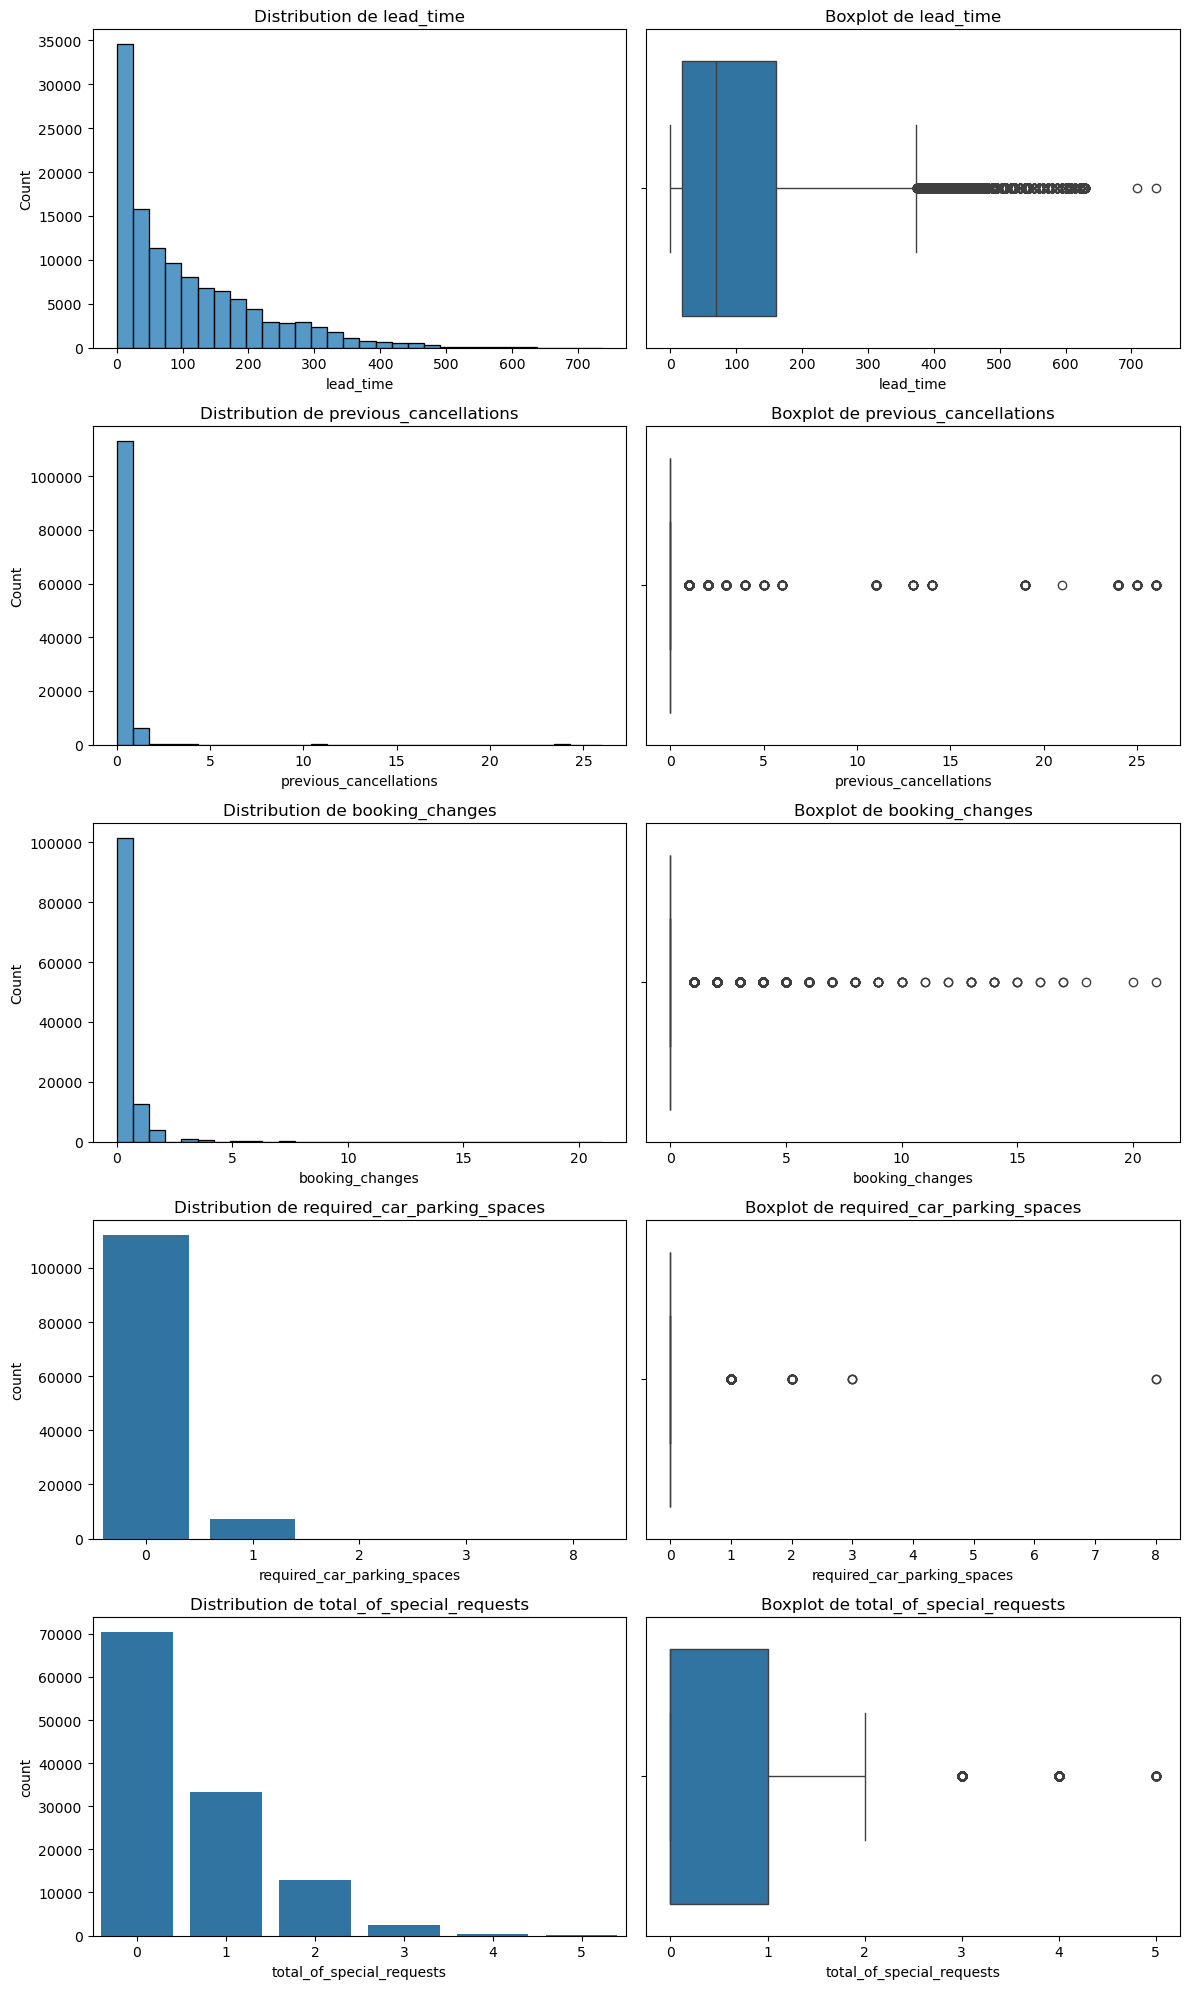

In [41]:
# Liste des variables numériques clés identifiées
significativ_numeric_vars = ["lead_time", "previous_cancellations", "booking_changes", 
                "required_car_parking_spaces", "total_of_special_requests" ]

# Création des figures avec 2 sous-graphiques (Histogramme + Boxplot) par variable
plt.figure(figsize=(12, len(significativ_numeric_vars) * 4))  # Adapter la taille selon le nombre de variables

for i, var in enumerate(significativ_numeric_vars):
    # Histogramme (ou countplot si peu de valeurs uniques)
    plt.subplot(len(significativ_numeric_vars), 2, 2*i + 1)
    if hotel_df[var].nunique() < 10:
        sns.countplot(x=hotel_df[var], order=hotel_df[var].value_counts().index)
    else:
        sns.histplot(hotel_df[var], bins=30)

    plt.title(f"Distribution de {var}")

    # Boxplot
    plt.subplot(len(significativ_numeric_vars), 2, 2*i + 2)
    sns.boxplot(x=hotel_df[var])
    plt.title(f"Boxplot de {var}")

plt.tight_layout()
plt.show()

  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">
     Analyse des distributions des variables numériques significatives 

Nous analysons la distribution des variables numériques identifiées comme influentes sur `is_canceled`.  
L’objectif est :  

- **Comprendre leur répartition** (asymétrie, valeurs extrêmes, déséquilibre).  
- **Identifier d’éventuels problèmes pour la modélisation** (valeurs rares, manque de variance, transformation nécessaire).  

**lead_time**  
- La distribution est **très asymétrique**, avec une forte concentration des valeurs **entre 0 et 25 jours**.  
- La **médiane** est à **70 jours**.  
- Les moustaches du boxplot s’étendent jusqu’à **380 jours**, mais des valeurs extrêmes dépassent **700 jours**.  
- **Actions possibles :**  
  - Transformation logarithmique pour réduire l’impact des valeurs extrêmes.  
  - Vérification des percentiles pour déterminer un seuil de capping.  
  - Analyse des lead_time très courts (<25 jours) pour détecter des tendances liées aux annulations.  

**previous_cancellations**  
- Distribution **extrêmement déséquilibrée** : la grande majorité des clients **n’ont jamais annulé**.  
- La **médiane est à 0** et les valeurs extrêmes atteignent **26 annulations**.  
- **Actions possibles :**  
  - Binarisation (`0 = aucune annulation`, `1 = au moins une annulation`).  
  - Analyse des percentiles pour fixer un seuil de capping.  
  - Étude de l’impact d’un historique d’annulations sur `is_canceled`.  

**booking_changes**  
- **Écrasante majorité** des réservations sans modification.  
- La **médiane est à 0**, avec des valeurs atteignant **plus de 20 changements**.  
- **Actions possibles :**  
  - Binarisation (`0 modification` vs  `au moins 1 modification`).  
  - Vérification des percentiles pour un éventuel capping des valeurs élevées.  
  - Analyse des clients ayant effectué de nombreuses modifications pour voir leur impact sur les annulations.  

**required_car_parking_spaces**  
- La quasi-totalité des réservations **ne demandent pas de place de parking**.  
- Très faible proportion avec **1 place**, et quelques valeurs extrêmes atteignant **8 places**.  
- **Actions possibles :**  
  - Binarisation (`0 = aucune place` / `1+ = au moins une place demandée`).  
  - Vérification de la cohérence des valeurs élevées et analyse d’un possible capping.  
  - Étude de la corrélation entre plusieurs places de parking et `is_canceled`.  

**total_of_special_requests**  
- Forte concentration sur **0 et 1 demande**, avec **très peu de valeurs au-delà de 3**.  
- La **médiane est à 1**, avec des valeurs maximales de **5 demandes spéciales**.  
- **Actions possibles :**  
  - Conserver la variable sous forme de **nombre exact** plutôt qu’une binarisation.  
  - Vérifier les percentiles pour un capping éventuel des valeurs élevées.  
  - Analyse de l’influence du nombre de demandes spéciales sur `is_canceled`.  

**Tendances communes et prochaines étapes**  
- **Forte asymétrie** dans plusieurs variables (`lead_time`, `previous_cancellations`, `booking_changes`), suggérant un **capping ou une transformation logarithmique**.  
- **Présence de valeurs extrêmes** dans toutes les variables analysées → Analyse des percentiles (95e, 99e) pour fixer des seuils pertinents.  
- **Variables avec des dominantes de 0** (`previous_cancellations`, `booking_changes`, `required_car_parking_spaces`) → Possibilité de **binarisation** si nécessaire.  

**Prochaine étape :**   
Vérification des distributions exactes (`value_counts()`, percentiles) avant d’appliquer des transformations dans le Data Preprocessing.  

**Cette analyse servira de base aux décisions de transformation des variables lors du Data Preprocessing.**



.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Vérification des valeurs extrêmes, analyse des percentiles et prise de décision sur les transformations  à effectuer

In [44]:
# Définition des seuils de percentiles à analyser
percentiles = [0.95, 0.99]

# Vérification de la répartition exacte des valeurs pour chaque variable numérique significative
# Calcul des percentiles pour chaque variable numérique significative
for var in significativ_numeric_vars:
    print(f"Répartition des valeurs pour {var} :")
    print(hotel_df[var].value_counts().sort_index())
    print("\n")
    print(f"Percentiles pour {var} :")
    print(hotel_df[var].quantile(percentiles))
    print("\n"*2)


Répartition des valeurs pour lead_time :
lead_time
0      6345
1      3460
2      2069
3      1816
4      1715
       ... 
622      17
626      30
629      17
709       1
737       1
Name: count, Length: 479, dtype: int64


Percentiles pour lead_time :
0.95    320.0
0.99    444.0
Name: lead_time, dtype: float64



Répartition des valeurs pour previous_cancellations :
previous_cancellations
0     112906
1       6051
2        116
3         65
4         31
5         19
6         22
11        35
13        12
14        14
19        19
21         1
24        48
25        25
26        26
Name: count, dtype: int64


Percentiles pour previous_cancellations :
0.95    1.0
0.99    1.0
Name: previous_cancellations, dtype: float64



Répartition des valeurs pour booking_changes :
booking_changes
0     101314
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
11         2
12         2
13         5
14         5
15         3

<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">  Analyse de la vérification des valeurs extrêmes, analyse des percentiles et prise de décision sur les transformations  à effectuer


Nous analysons ici la répartition des valeurs extrêmes pour les variables numériques influentes sur `is_canceled`. L'objectif est de :  

- **Identifier des valeurs rares** pouvant nuire à la robustesse du modèle.  
- **Fixer des seuils pertinents** pour limiter leur impact sans perdre d’information utile.  
- **Explorer les transformations possibles** (`capping`, `binarisation`, `transformation logarithmique`).  

**1- lead_time**  

`Analyse des valeurs extrêmes`  
- La distribution est très étalée, avec **479 valeurs uniques** et des réservations allant jusqu'à **737 jours en avance**.  
- **95 % des valeurs** sont ≤ **320 jours**, et **99 %** sont ≤ **444 jours**.  
- **1% des valeurs restantes sont très élevées**, mais elles ne sont pas forcément aberrantes.  

`Propositions de transformation`  
- **Transformation logarithmique (`log(lead_time + 1)`)** pour atténuer l’effet des valeurs extrêmes.  
- **Capping à 320 jours (95e percentile)** pour limiter les valeurs élevées tout en conservant la majorité des données.  
- **Capping à 444 jours (99e percentile)** pour un compromis entre conservation des données et réduction des valeurs extrêmes.  

`Décision :` Tester d’abord la **transformation logarithmique**. Si elle n’améliore pas le modèle, appliquer un **capping à 320 jours**.  

**2- previous_cancellations**  

`Analyse des valeurs extrêmes`  
- **95 % des valeurs sont 0 ou 1**, la variable est **fortement déséquilibrée**.  
- **Les valeurs supérieures à 1 sont ultra-rares** et ne représentent que **moins de 1 % des observations**.  

`Propositions de transformation`  
- **Binarisation (`0 = jamais annulé` / `1 = au moins une annulation`)** : permet de simplifier la variable tout en conservant l'information clé.  
- **Capping à 1** : remplace toutes les valeurs >1 par 1 pour éviter l'effet des valeurs rares.  

`Décision :` Appliquer une **binarisation**, car **99 % des valeurs sont déjà 0 ou 1**.  

**3- booking_changes**  

`Analyse des valeurs extrêmes`  
- **95 % des réservations ont été modifiées au maximum 1 fois**, et **99 % au maximum 3 fois**.  
- **Les valeurs supérieures à 3 sont extrêmement rares**, ce qui pourrait introduire du bruit dans le modèle.  

`Propositions de transformation`  
- **Binarisation (`0 = aucune modification` / `1 = au moins une modification`)** si seule la distinction "modifié vs non modifié" est pertinente.  
- **Capping à 3** : limiter les valeurs à **3 maximum** pour éviter l’influence des valeurs extrêmes.  

`Décision :` Appliquer un **capping à 3** tout en testant son impact sur la performance du modèle.  

**4- required_car_parking_spaces**  

`Analyse des valeurs extrêmes`  
- **93.8 % des réservations n’ont pas demandé de place de parking (0)**.  
- **99 % des clients ont demandé au maximum 1 place**, et les valeurs >1 sont **quasi inexistantes**.  

`Propositions de transformation`  
- **Binarisation (`0 = aucune place` / `1+ = au moins une place`)** car les valeurs >1 sont trop rares pour être significatives.  

`Décision :` Appliquer une **binarisation** (`0 = aucune place` / `1 = au moins une place demandée`).  

**5- total_of_special_requests**  

`Analyse des valeurs extrêmes`  
- **95 % des réservations ont fait au maximum 2 demandes spéciales**, et **99 % au maximum 3**.  
- **Les valeurs supérieures à 3 sont très rares (~0.3 %)**, ce qui pourrait justifier un capping.  

`Propositions de transformation`  
- **Capping à 3** : toutes les valeurs >3 deviennent 3 pour éviter l’impact des valeurs rares.  
- **Conservation de la variable telle quelle**, si le nombre exact de demandes spéciales influence `is_canceled`.  

`Décision :` Conserver la variable **telle quelle** pour  comparer les taux d’annulation (`is canceled`) par nombre de demandes spéciales. Si les valeurs **4 et 5** n’ont pas d’influence significative, un **capping à 3** sera appliqué.  

**Synthèse des décisions**  

| **Variable** | **Transformation appliquée** |
|-------------|------------------------------|
| `lead_time` | Transformation logarithmique ou capping à 320 jours |
| `previous_cancellations` | Binarisation (`0 = jamais annulé`, `1 = au moins une annulation`) |
| `booking_changes` | Capping à 3 |
| `required_car_parking_spaces` | Binarisation (`0 = aucune place`, `1 = au moins une place demandée`) |
| `total_of_special_requests` | Conserver tel quel, puis tester un capping à 3 si nécessaire |


### **4.1.3 Récapitulatif des décisions sur les transformations à appliquer (variables numériques)**

<p style="background-color:Gold;color:black; font-weight:bold; font-size:18px;text-align:center;">
    Récapitulatif des variables numériques significatives et transformations à appliquer

**Variables numériques significatives identifiées**   
Nous avons sélectionné les variables numériques ayant une influence notable sur `is_canceled`.  
L’analyse de **Pearson** et des **distributions** a permis d’identifier ces variables et de définir les transformations nécessaires avant leur intégration dans un modèle prédictif.

.  
**Liste des variables numériques significatives :**  
| **Variable** | **Corrélation avec is_canceled** | **Problèmes identifiés** |
|-------------|-------------------------------|---------------------------|
| `lead_time` | **+0.293** | Distribution très asymétrique, impact des valeurs extrêmes |
| `previous_cancellations` | **+0.110** | Déséquilibre (majorité de 0), rares valeurs très élevées |
| `booking_changes` | **-0.144** | Majorité de 0, quelques valeurs élevées |
| `required_car_parking_spaces` | **-0.195** | Majorité de 0, faible variance |
| `total_of_special_requests` | **-0.234** | Quelques valeurs élevées peu fréquentes |
  
.  
**Transformations prévues pour la modélisation**  
Certaines variables nécessitent des transformations avant leur utilisation dans un modèle.  
Les choix de transformations sont basés sur les analyses de distribution, d’outliers et de variabilité.

| **Variable** | **Transformation à appliquer** | **Justification** |
|-------------|------------------------------|-------------------|
| `lead_time` | **Transformation logarithmique** | Réduire l’impact des valeurs extrêmes |
| `previous_cancellations` | **Binarisation (`0 = jamais annulé`, `1 = au moins une annulation`)** | La plupart des valeurs sont 0, peu de variance au-delà de 1 |
| `booking_changes` | **Capping à 3** | Éviter l’impact des valeurs très rares supérieures à 3 |
| `required_car_parking_spaces` | **Binarisation (`0 = aucune place`, `1+ = au moins une place demandée`)** | La quasi-totalité des valeurs >1 sont rares et peu significatives |
| `total_of_special_requests` | **Conserver tel quel, puis tester un capping à 3 si nécessaire** | Vérifier si les valeurs élevées influencent `is_canceled` |
  
.  
**Transition vers le Data Preprocessing**  
Afin de conserver une **séparation stricte entre l’EDA et le Data Preprocessing**, **aucune transformation n’est appliquée ici**.  
Les modifications mentionnées ci-dessus seront mises en œuvre **dans la partie Data Preprocessing**, où nous validerons leur impact sur la distribution des variables et la performance du modèle.



## **4.2 Identification des Variables Catégorielles Significatives**

### **4.2.1 Identification des variables catégorielles significatives (corrélation avec is_canceled)**

.  
 
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de hotel sur is_canceled

Nombre de reservations par type d'hôtel
 hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64

Taux d'annulation par type d'hôtel :
               Confirmé     Annulé
hotel                             
City Hotel    58.273037  41.726963
Resort Hotel  72.236645  27.763355


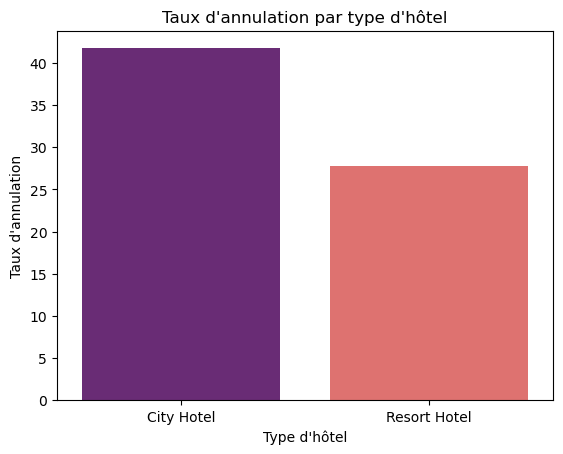

In [51]:
# Compter le nombre de reservations par type d'hôtel
hotel_counts = hotel_df['hotel'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par type d'hôtel\n",hotel_counts)

# Calcul du taux d'annulation par type d'hôtel
hotel_analysis = pd.crosstab(hotel_df['hotel'], hotel_df['is_canceled'], normalize='index') * 100
hotel_analysis.columns = ['Confirmé', 'Annulé']
hotel_analysis = hotel_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type d'hôtel :")
print(hotel_analysis)

# Barplot des taux d'annulation par type d'hôtel
sns.barplot(x=hotel_analysis.index, y=hotel_analysis['Annulé'], 
            hue=hotel_analysis.index,
            palette='magma')
plt.title("Taux d'annulation par type d'hôtel")
plt.xlabel("Type d'hôtel")
plt.ylabel("Taux d'annulation")
plt.show()

 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par type d’hôtel
  
**Observations principales :**  
- **Le taux d’annulation est plus élevé pour les "City Hotels" (41.7 %)** que pour les "Resort Hotels" (27.8 %).  
- **Les "City Hotels" enregistrent un volume de réservations plus élevé** (79 330 contre 40 060), ce qui renforce la fiabilité de cette tendance. 
  

**Interprétation :**  
- **Le taux d’annulation plus élevé des hôtels en ville** peut être lié à plusieurs facteurs :  
  - **Flexibilité des réservations** : Les séjours en ville sont plus souvent courts et ajustables.  
  - **Voyages d’affaires et incertitudes** : Les hôtels urbains attirent davantage de professionnels qui annulent selon leurs impératifs.  
  - **Concurrence et alternatives** : Une plus grande offre d’hôtels en ville peut inciter les clients à changer de réservation. 
- **Les hôtels "Resort" affichent un taux d’annulation plus faible**, ce qui peut être dû à :  
  - **Une planification plus rigoureuse des séjours de vacances.**  
  - **Des politiques d’annulation plus strictes ou des séjours prépayés.** 

**Conclusion :**     
 <p style="background-color:lightgreen; color:black; font-weight:bold;">hotel est une variable significative.

.  

 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de meal sur is_canceled


Nombre de reservations par type de repas
 meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64

Taux d'annulation par type de repas :
            Confirmé     Annulé
meal                           
FB         40.100251  59.899749
BB         62.615101  37.384899
SC         62.760563  37.239437
HB         65.539653  34.460347
Undefined  75.534645  24.465355


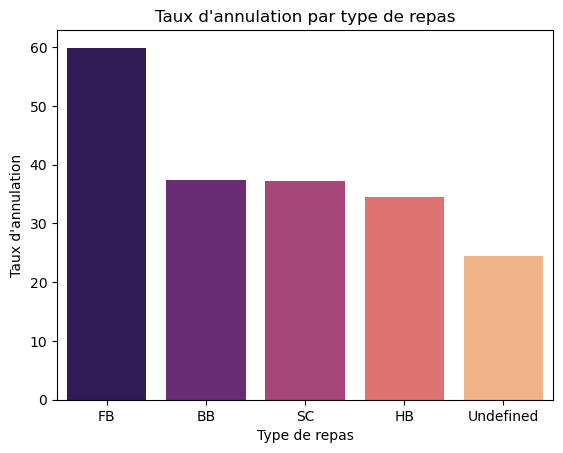

In [54]:
"""(meal = Undefined/SC = no meal package; 
BB = Bed & Breakfast; 
HB = Half board (breakfast and one other meal – usually dinner); 
FB = Full board (breakfast, lunch and dinner)"""

# Compter le nombre de reservations par type repas
meal_counts = hotel_df['meal'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par type de repas\n",meal_counts,)

# Calcul du taux d'annulation par type de repas 
meal_analysis = pd.crosstab(hotel_df['meal'], hotel_df['is_canceled'], normalize='index') * 100
meal_analysis.columns = ['Confirmé', 'Annulé']
meal_analysis = meal_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type de repas :")
print(meal_analysis)

# Barplot des taux d'annulation par type de repas
sns.barplot(x=meal_analysis.index, y=meal_analysis['Annulé'], 
            hue=meal_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par type de repas")
plt.xlabel("Type de repas")
plt.ylabel("Taux d'annulation")
plt.show()

<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par type de repas  

L’analyse des annulations en fonction du type de repas montre **une différence notable pour certaines catégories** :  
- Le taux d’annulation est particulièrement élevé pour **`FB` (59.9 %)**, tandis qu’il est plus faible pour **`Undefined` (24.5 %)**.  
- Les autres types de repas **ont des taux similaires**, autour de **34 % à 37 %**.  

.  
**Pourquoi `FB` présente-t-il un taux d’annulation plus élevé ?**  
Plusieurs hypothèses peuvent être avancées :  
1. **Réservations de groupe ou longues durées**  
   - Les formules `FB` sont souvent choisies par des groupes, des familles ou des séjours prolongés.  
   - Ces réservations peuvent être plus sujettes à des changements imprévus, notamment des annulations.  

2. **Moins de flexibilité**  
   - Un engagement financier plus important pourrait être associé à des conditions de modification plus strictes.  
   - **Si les conditions de modification sont moins souples, certains clients pourraient préférer annuler complètement et réserver ailleurs.**  

3. **Type de clientèle différent**  
   - Les clients qui optent pour `FB` pourraient être **des vacanciers internationaux** ayant des contraintes plus fortes (ex: vols, visas).  
   - En cas de problème (vol annulé, budget revu à la baisse, changement de programme), ils sont plus enclins à **annuler leur séjour complet** plutôt que de modifier simplement la réservation.  

4. **Offre moins répandue = Moins de stabilité ?**  
   - `FB` est le **type de repas le moins réservé (seulement 798 réservations)**.  
   - Il est possible que ces réservations soient plus sensibles à des conditions particulières (moins d'offres, prix plus élevés, etc.), ce qui les rend plus instables.

**Conclusion :**   
<p style="background-color:lightgreen; color:black; font-weight:bold;"> meal est une variable significative.  

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">
Analyse de l’impact de country_grouped sur is_canceled
      
Le problème pour analyser country est qu'il y a énormément de catégories (pays) ce qui rendrait l'analyse illisible si on affichait toutes les valeurs.  
Mais la majorité des réservations viennent de quelques pays, on peut donc créer une nouvelle version modifiée country_grouped de la colonne country sur le dataset et filtrer les pays les plus représentés afin de voir leur impact sur is_canceled.  
***filtre: pays avec au moins 500 occurrences***

Nombre de reservations par pays
 country_grouped
PRT       49078
GBR       12129
FRA       10415
ESP        8568
DEU        7287
Others     6883
ITA        3766
IRL        3375
BEL        2342
BRA        2224
NLD        2104
USA        2097
CHE        1730
CN         1279
AUT        1263
SWE        1024
CHN         999
POL         919
ISR         669
RUS         632
NOR         607
Name: count, dtype: int64

Taux d'annulation par pays :
                  Confirmé     Annulé
country_grouped                      
PRT              43.791516  56.208484
CHN              53.753754  46.246246
RUS              62.183544  37.816456
BRA              62.679856  37.320144
ITA              64.604355  35.395645
Others           69.577219  30.422781
NOR              70.181219  29.818781
ESP              74.591503  25.408497
ISR              74.738416  25.261584
CHE              75.260116  24.739884
IRL              75.348148  24.651852
USA              76.108727  23.891273
POL              76.605005 

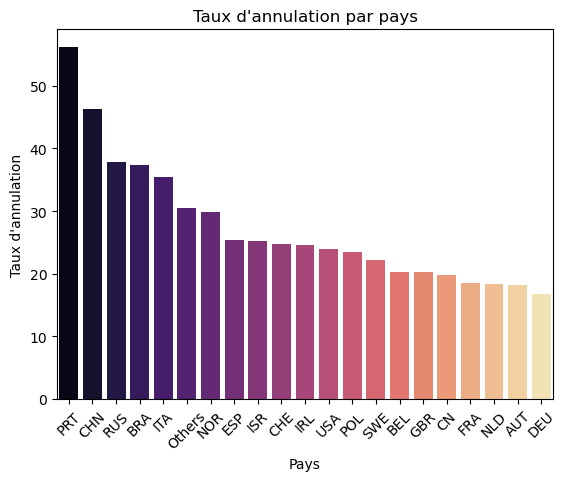

In [57]:
#Nombre minimum d'occurrences pour afficher un pays
min_count = 500  
# Filtrer les pays avec un nombre d'occurrences suffisant
top_countries = hotel_df["country"].value_counts()
top_countries = top_countries[top_countries > min_count].index

# Filtrer le dataset pour ne garder que ces pays
hotel_df["country_grouped"] = hotel_df["country"].apply(lambda x: x if x in top_countries else 'Others')

# Compter le nombre de reservations par pays
country_grouped_counts = hotel_df['country_grouped'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par pays\n",country_grouped_counts,)

# Calcul du taux d'annulation par pays
country_grouped_analysis = pd.crosstab(hotel_df['country_grouped'], hotel_df['is_canceled'], normalize='index') * 100
country_grouped_analysis.columns = ['Confirmé', 'Annulé']
country_grouped_analysis = country_grouped_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par pays :")
print(country_grouped_analysis)


# Barplot des taux d'annulation par pays
sns.barplot(x=country_grouped_analysis.index, y=country_grouped_analysis['Annulé'], 
            hue=country_grouped_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par pays")
plt.xlabel("Pays")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()

 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par pays  

L’analyse des annulations selon le pays montre **de fortes disparités** dans les comportements de réservation et d’annulation.  

**Observations principales :**  
- **Le taux d’annulation varie considérablement selon le pays**, allant de **16.7 % (Allemagne)** à **56.2 % (Portugal)**.  
- **Les clients portugais (`PRT`) ont le taux d’annulation le plus élevé (56.2 %)**, ce qui pourrait être lié à des facteurs internes, comme des habitudes de réservation différentes ou des conditions d’annulation plus souples pour certaines catégories de clients.  
- **Les clients allemands (`DEU`) et autrichiens (`AUT`) ont des taux d’annulation beaucoup plus faibles (~16-18 %)**, suggérant des comportements de réservation plus engageants.  

**Interprétation :**  
- Le taux d’annulation **semble lié aux habitudes de réservation spécifiques à chaque pays**, mais aussi aux **canaux de distribution** utilisés.  
- Certains pays pourraient avoir des **politiques d’annulation différentes**, influençant les décisions des clients.  
- Les pays ayant un **taux d’annulation très bas pourraient être plus enclins à effectuer des réservations confirmées à l’avance**, tandis que d’autres pourraient utiliser des **réservations plus flexibles et sujettes aux changements**.  

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;"> country_grouped est une variable significative.

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de market_segment sur is_canceled

Nombre de reservations par segment
 market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64

Taux d'annulation par segment de marché :
                 Confirmé      Annulé
market_segment                       
Undefined        0.000000  100.000000
Groups          38.937964   61.062036
Online TA       63.278857   36.721143
Offline TA/TO   65.683967   34.316033
Aviation        78.059072   21.940928
Corporate       81.265345   18.734655
Direct          84.658099   15.341901
Complementary   86.944818   13.055182


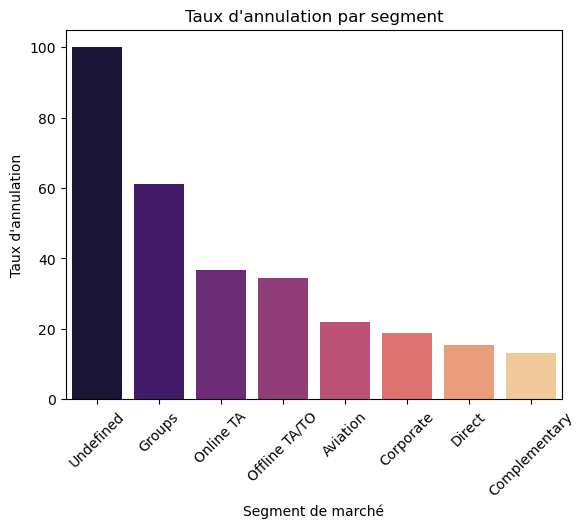

In [60]:
# Compter le nombre de reservations par type segment
market_segment_counts = hotel_df['market_segment'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par segment\n",market_segment_counts,)


# Calcul du taux d'annulation par segment de marché
market_segment_analysis = pd.crosstab(hotel_df['market_segment'], hotel_df['is_canceled'], normalize='index') * 100
market_segment_analysis.columns = ['Confirmé', 'Annulé']
market_segment_analysis = market_segment_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par segment de marché :")
print(market_segment_analysis)


# Barplot des taux d'annulation par segment
sns.barplot(x=market_segment_analysis.index, y=market_segment_analysis['Annulé'], 
            hue=market_segment_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par segment")
plt.xlabel("Segment de marché")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()

 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par segment de marché  

L’analyse des annulations en fonction du segment de marché révèle **de fortes disparités** entre les catégories :  
- **Le segment "Groups" a le taux d’annulation le plus élevé (61.1 %)**, ce qui peut s'expliquer par la nature des réservations de groupe, souvent soumises à des changements de dernière minute.  
- **Les segments "Online TA" et "Offline TA/TO" affichent également des taux élevés (~35 %)**, ce qui est cohérent avec la flexibilité généralement offerte par ces plateformes de réservation.  
- **Les segments "Direct", "Corporate" et "Complementary" ont des taux d’annulation plus faibles (<20 %)**, suggérant que ces clients sont plus engagés et moins enclins à annuler.  
- **Le segment "Undefined" présente un taux d’annulation de 100 %**, mais il ne contient que **2 réservations**, rendant cette information non exploitable.  
   
**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">market_segment est une variable significative.

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de distribution_channel sur is_canceled

Nombre de reservations par distribution_channel
 distribution_channel
TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: count, dtype: int64

 Taux d'annulation par canal de distribution :
                       Confirmé     Annulé
distribution_channel                      
Undefined             20.000000  80.000000
TA/TO                 58.974149  41.025851
Corporate             77.924217  22.075783
GDS                   80.829016  19.170984
Direct                82.540116  17.459884


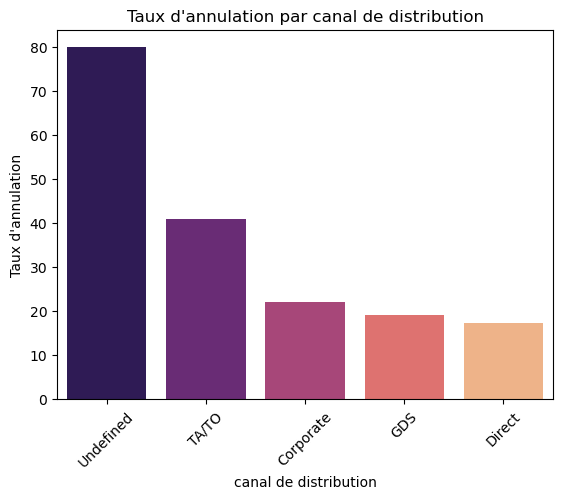

In [63]:
# Compter le nombre de reservations par canal de distribution
distribution_channel_counts = hotel_df['distribution_channel'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par distribution_channel\n",distribution_channel_counts,)


# Calcul du taux d'annulation par canal de distribution
distribution_channel_analysis = pd.crosstab(hotel_df['distribution_channel'], hotel_df['is_canceled'], normalize='index') * 100
distribution_channel_analysis.columns = ['Confirmé', 'Annulé']
distribution_channel_analysis = distribution_channel_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\n Taux d'annulation par canal de distribution :")
print(distribution_channel_analysis)

# Barplot des taux d'annulation par canal de distribution
sns.barplot(x=distribution_channel_analysis.index, y=distribution_channel_analysis['Annulé'], 
            hue=distribution_channel_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par canal de distribution")
plt.xlabel("canal de distribution")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par canal de distribution  

L’analyse des annulations en fonction du canal de distribution révèle **des écarts significatifs** :  
- **Le canal `TA/TO` affiche le taux d’annulation le plus élevé (41 %)**, ce qui est cohérent avec la flexibilité généralement offerte par ces plateformes de réservation.  
- **Les canaux `Corporate`, `GDS` et `Direct` ont des taux d’annulation bien plus faibles (entre 17 % et 22 %)**, suggérant des réservations plus engagées et moins sujettes aux annulations.  
- **Le canal `Undefined` présente un taux d’annulation de 80 %**, mais avec seulement **5 réservations**, cette information est peu exploitable.  


**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">distribution_channel est une variable significative. 

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de reserved_room_type sur is_canceled

In [66]:
# Calcul du taux d'annulation par type de chambre réservée
reserved_room_analysis = pd.crosstab(hotel_df['reserved_room_type'], hotel_df['is_canceled'], normalize='index') * 100
reserved_room_analysis.columns = ['Confirmé', 'Annulé']

# Affichage du tableau
print("\nTaux d'annulation par type de chambre réservée :")
print(reserved_room_analysis)


Taux d'annulation par type de chambre réservée :
                     Confirmé      Annulé
reserved_room_type                       
A                   60.892620   39.107380
B                   67.084079   32.915921
C                   66.952790   33.047210
D                   68.220405   31.779595
E                   70.711553   29.288447
F                   69.623749   30.376251
G                   63.562560   36.437440
H                   59.234609   40.765391
L                   66.666667   33.333333
P                    0.000000  100.000000


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par type de chambre réservée  

L’analyse des annulations en fonction du type de chambre réservée **ne révèle pas de tendance significative** :  
- La majorité des types de chambres affichent un taux d’annulation compris entre **29 % et 41 %**, sans variation marquée.  
- **Le type de chambre "P" présente un taux d’annulation de 100 %**, mais compte tenu de son faible nombre d’occurrences, cette donnée est probablement **non représentative**.  

<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    reserved_room_type n'est pas une variable significative.  
    
Les différences observées entre les catégories sont **modérées et peu exploitées pour la prédiction**, à l’exception de la chambre "P", qui semble être un cas isolé.  


.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de assigned_room_type sur is_canceled

In [69]:
# Calcul du taux d'annulation par type de chambre assignée
assigned_room_analysis = pd.crosstab(hotel_df['assigned_room_type'], hotel_df['is_canceled'], normalize='index') * 100
assigned_room_analysis.columns = ['Confirmé', 'Annulé']

# Affichage du tableau
print("\nTaux d'annulation par type de chambre assignée :")
print(assigned_room_analysis)



Taux d'annulation par type de chambre assignée :
                     Confirmé      Annulé
assigned_room_type                       
A                   55.507542   44.492458
B                   76.329172   23.670828
C                   81.221053   18.778947
D                   74.875602   25.124398
E                   74.788624   25.211376
F                   75.286590   24.713410
G                   69.447709   30.552291
H                   64.747191   35.252809
I                   98.622590    1.377410
K                   95.698925    4.301075
L                    0.000000  100.000000
P                    0.000000  100.000000


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par type de chambre assignée  

L’analyse des annulations en fonction du type de chambre assignée **montre quelques variations, mais sans tendance réellement exploitable** :  
- **Le type de chambre "A" présente le taux d’annulation le plus élevé parmi les catégories courantes (44.5 %)**, mais l’écart avec les autres types reste modéré.  
- **Les types "L" et "P" affichent un taux d’annulation de 100 %**, mais leur faible occurrence suggère une **anomalie ou un manque de données**.  
- **Les autres catégories se situent entre 13 % et 35 %**, ce qui **ne dégage pas de modèle clair** influençant directement les annulations.  

<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    assigned_room_type n'est pas une variable significative. 
    
Les différences observées sont **insuffisamment marquées pour être exploitées dans la modélisation**.  
Les taux d’annulation extrêmes de certaines catégories semblent **refléter des spécificités ponctuelles plutôt qu’une tendance générale**.  

.  

 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Création de la variable room_change et analyse de l'impact avec is_canceled
     
**Nous avons vu que reserved_room et assigned_room ne sont pas des variables clés. Cela dit, il pourrait être bon de vérifier si la chambre réservée (reserved_room) est la même que la chambre assignée (assigned_room).**  
En effet, il se pourrait que des annulations soient liées au fait que la chambre assignée est différente de celle réservée.  
  
Nous allons donc créer une nouvelle variable binaire `room_change` qui prendra **1 si la chambre assignée est différente de la chambre réservée et sinon 0.**

In [72]:
# Création de la variable binaire (1 si la chambre assignée est différente de la chambre réservée)
hotel_df['room_change'] = (hotel_df['reserved_room_type'] != hotel_df['assigned_room_type']).astype(int)


# Compter le nombre de reservations par room_change
room_change_counts = hotel_df['room_change'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par room_change\n",room_change_counts,)

# Calcul du taux d'annulation selon room_change
room_change_analysis = pd.crosstab(hotel_df['room_change'], hotel_df['is_canceled'], normalize='index') * 100
room_change_analysis.columns = ['Confirmé', 'Annulé']
room_changel_analysis = room_change_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation selon le changement de chambre :")
print(room_change_analysis)

Nombre de reservations par room_change
 room_change
0    104473
1     14917
Name: count, dtype: int64

Taux d'annulation selon le changement de chambre :
              Confirmé     Annulé
room_change                      
0            58.437108  41.562892
1            94.623584   5.376416


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation selon le changement de chambre  

L’analyse des annulations en fonction du changement de chambre **montre une forte différence entre les catégories** :  
- **Les réservations sans changement de chambre (`room_change = 0`) ont un taux d’annulation élevé (41.6 %)**.  
- **Les réservations avec un changement de chambre (`room_change = 1`) ont un taux d’annulation beaucoup plus faible (5.4 %)**.  

**Interprétation :**  
- À première vue, on pourrait penser que le changement de chambre **réduit fortement les annulations**.  
- Cependant, **cette relation est probablement due à un effet de temporalité** :  
  - Les changements de chambre se produisent souvent **peu avant l’arrivée**, lorsque l’annulation **n’est plus une option viable**, car le client est pris au dépourvu.    
  - Il est également possible que ces clients aient accepté des modifications pour éviter une annulation.  
    

**Conclusion :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    room_change n'est pas une variable significative.  

- **Le faible taux d’annulation observé pour `room_change = 1` ne signifie pas que cette variable influence directement les annulations.**  
- L’écart semble être **une conséquence du moment où les changements de chambre ont lieu**, plutôt qu’un véritable facteur explicatif.  

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de deposit_type sur is_canceled

Nombre de reservations par deposit_type
 deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64

Taux d'annulation par type de dépôt :
               Confirmé     Annulé
deposit_type                      
Non Refund     0.637554  99.362446
No Deposit    71.622978  28.377022
Refundable    77.777778  22.222222


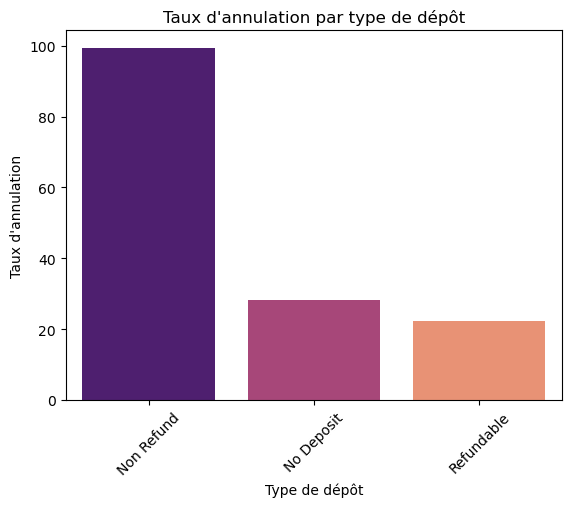

In [75]:
# Compter le nombre de reservations par type de dépôt
deposit_type_counts = hotel_df['deposit_type'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par deposit_type\n",deposit_type_counts,)

# Calcul du taux d'annulation par type de dépôt
deposit_type_analysis = pd.crosstab(hotel_df['deposit_type'], hotel_df['is_canceled'], normalize='index') * 100
deposit_type_analysis.columns = ['Confirmé', 'Annulé']
deposit_type_analysis = deposit_type_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type de dépôt :")
print(deposit_type_analysis)

# Barplot des taux d'annulation par type de dépôt
sns.barplot(x=deposit_type_analysis.index, y=deposit_type_analysis['Annulé'], 
            hue=deposit_type_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par type de dépôt")
plt.xlabel("Type de dépôt")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()


<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par type de dépôt  

L’analyse des annulations en fonction du type de dépôt révèle **une différence très marquée entre les catégories** :  
- **Les réservations avec un dépôt "Non Refund" affichent un taux d’annulation extrêmement élevé (99.4 %)**.  
- **Les réservations sans dépôt ("No Deposit") ont un taux d’annulation de 28.4%**, ce qui est bien plus faible.  
- **Les réservations avec dépôt remboursable ("Refundable") ont le taux d’annulation le plus bas (22.2 %)**, ce qui est logique, car ces clients peuvent récupérer leur dépôt sans pénalité.  

**Interprétation :**  
- Le **taux d’annulation élevé pour "Non Refund"** semble contre-intuitif, puisqu'on pourrait penser qu’un paiement non remboursable dissuade l’annulation.  
- Cela peut être lié à des stratégies commerciales :  
  - Certaines offres "Non Refund" sont proposées à bas prix, attirant des clients plus enclins à annuler en cas de changement de plans.  
  - Ces réservations pourraient aussi être surreprésentées chez certains segments à fort taux d’annulation (ex: `market_segment` et `distribution_channel`).  
- Il faudra **croiser `deposit_type` avec d'autres variables** pour mieux comprendre cette dynamique.  
 

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">deposit_type est une variable significative. 

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de customer_type sur is_canceled

Nombre de reservations par customer_type
 customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64

Taux d'annulation par type de client :
                  Confirmé     Annulé
customer_type                        
Transient        59.253680  40.746320
Contract         69.038273  30.961727
Transient-Party  74.570132  25.429868
Group            89.774697  10.225303


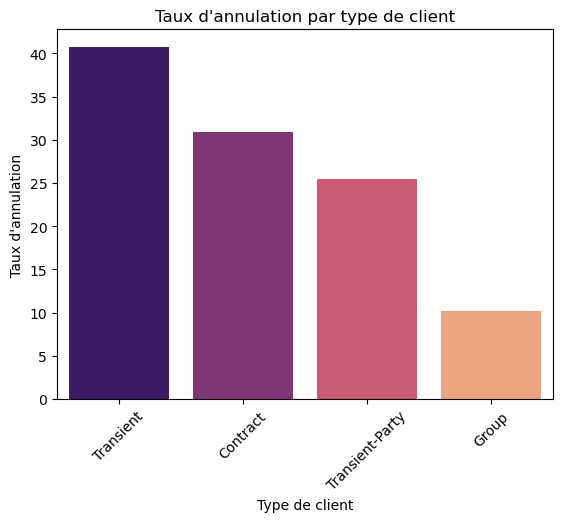

In [78]:
# Compter le nombre de reservations par type de client
customer_type_counts = hotel_df['customer_type'].value_counts().sort_values(ascending=False)
print("Nombre de reservations par customer_type\n",customer_type_counts,)

# Calcul du taux d'annulation par type de client
customer_type_analysis = pd.crosstab(hotel_df['customer_type'], hotel_df['is_canceled'], normalize='index') * 100
customer_type_analysis.columns = ['Confirmé', 'Annulé']
customer_type_analysis = customer_type_analysis.sort_values(by="Annulé", ascending=False)

# Affichage du tableau
print("\nTaux d'annulation par type de client :")
print(customer_type_analysis)

# Barplot des taux d'annulation par type de client
sns.barplot(x=customer_type_analysis.index, y=customer_type_analysis['Annulé'], 
            hue=customer_type_analysis.index, 
            palette='magma', legend=False)
plt.title("Taux d'annulation par type de client")
plt.xlabel("Type de client")
plt.ylabel("Taux d'annulation")
plt.xticks(rotation=45)
plt.show()

<p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par type de client  

L’analyse des annulations en fonction du type de client met en évidence **des écarts significatifs** :  
- **Les clients "Transient" ont le taux d’annulation le plus élevé (40.7 %)**, ce qui peut s'expliquer par une plus grande flexibilité et une moindre contrainte financière.  
- **Les clients "Contract" et "Transient-Party" affichent des taux d’annulation plus modérés (31 % et 25.4 %)**, indiquant un engagement légèrement plus fort.  
- **Les clients "Group" ont le taux d’annulation le plus bas (10.2 %)**, ce qui peut être dû à des contrats plus stricts ou des réservations planifiées longtemps à l’avance.  

**Interprétation :**  
- Les **clients "Transient" semblent être les plus volatils**, ce qui peut être lié à des réservations individuelles plus spontanées.  
- À l’inverse, les **réservations de groupes et sous contrat sont plus stables**, car elles sont souvent planifiées à l’avance et encadrées par des accords spécifiques.  
- **Le type de client influence donc directement le taux d’annulation.**  

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">customer_type est une variable significative.  

.  
 <p style="background-color:blue; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de reservation_status sur is_canceled

In [81]:
# Calcul du taux d'annulation par statut de réservation
reservation_status_analysis = pd.crosstab(hotel_df['reservation_status'], hotel_df['is_canceled'], normalize='index') * 100
reservation_status_analysis.columns = ['Confirmé', 'Annulé']

# Affichage du tableau
print("\nTaux d'annulation par statut de réservation :")
print(reservation_status_analysis)


Taux d'annulation par statut de réservation :
                    Confirmé  Annulé
reservation_status                  
Canceled                 0.0   100.0
Check-Out              100.0     0.0
No-Show                  0.0   100.0


 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;">Analyse du taux d’annulation par statut de réservation
     
Sans grande surprise, **100 % des réservations avec le statut "Canceled" ou "No-Show" sont annulées**, tandis que **100 % des réservations "Check-Out" sont confirmées**.  

<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    reservation_status n'est pas une variable significative.  
    
Cette variable n’apporte **aucune valeur prédictive** pour l’analyse, car **`is_canceled` et `reservation_status` sont directement liés**.  
Elle sera donc **exclue** des variables explicatives lors de l’EDA et du modèle prédictif.  


.  

.
  
  <p style="background-color:blue;color:white; font-weight:bold; font-size:15px;text-align:center;">
Récapitulatif des variables catégorielles significatives identifiées

Après l’analyse des différentes variables, voici la liste des variables ayant une **influence significative** sur les annulations (`is_canceled`).  

| **Variables clés** | **Pourquoi ?** |
|-------------------|---------------|
| **hotel** | Les City Hotels ont un taux d’annulation plus élevé que les Resort Hotels. |
| **meal** | Certains types de repas (ex: FB) sont associés à un taux d’annulation plus élevé. |
| **country_grouped** | Les taux d’annulation varient fortement en fonction du pays des clients. |
| **market_segment** | Les groupes et les agences influencent différemment le taux d’annulation. |
| **distribution_channel** | Certains canaux de distribution affichent un taux d’annulation nettement plus élevé. |
| **deposit_type** | Les clients ayant payé un dépôt "Non Refund" annulent paradoxalement plus souvent. |
| **customer_type** | Les clients "Transient" ont un taux d’annulation beaucoup plus élevé que les groupes ou les contrats. |



### **4.2.2 Distribution des variables catégorielles significatives**

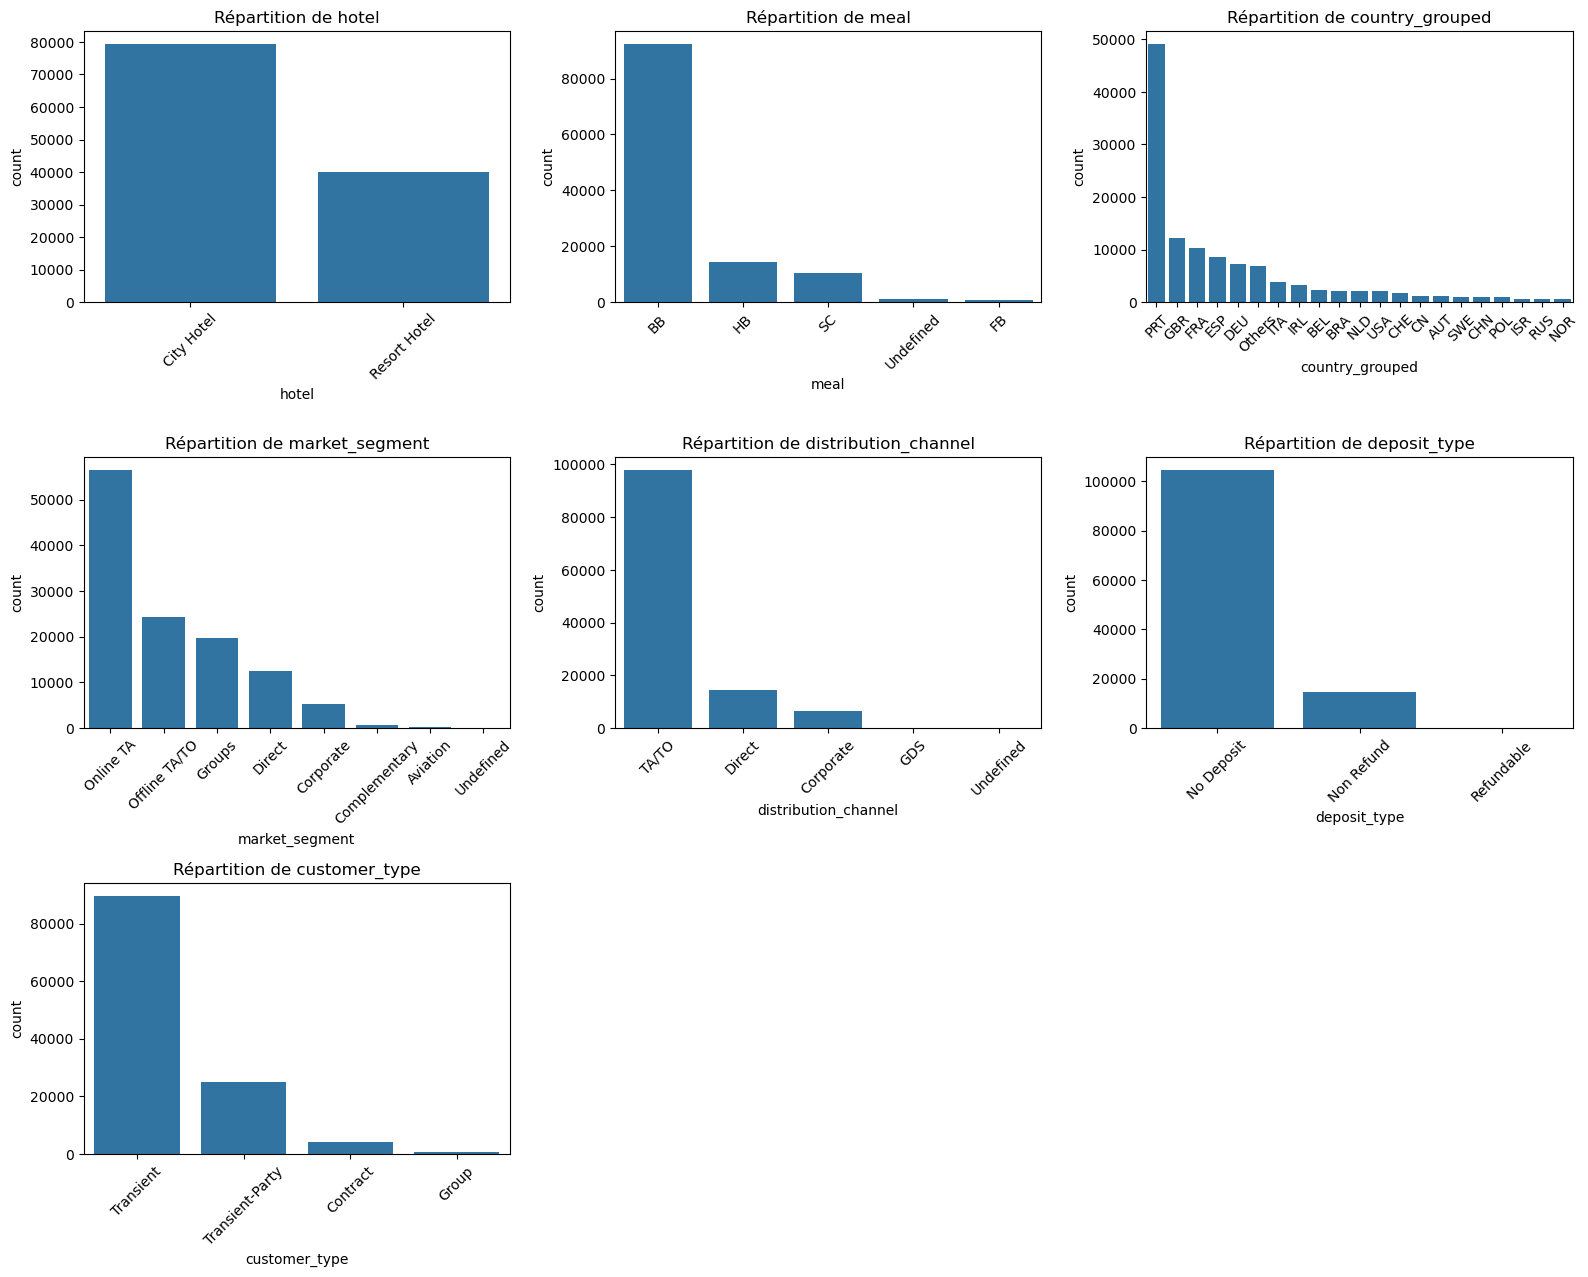

In [85]:
# Liste des variables catégorielles significatives (country_grouped = les pays les plus représentés avec min 500 occurences)
singificativ_categorical_vars = ["hotel", "meal", "country_grouped", "market_segment", "distribution_channel",
                        "deposit_type", "customer_type"]

# Création des barplots
plt.figure(figsize=(16, 16))
for i, var in enumerate(singificativ_categorical_vars, 1):
    plt.subplot(4, 3, i)  # Ajuster la disposition selon le nombre de variables
    sns.countplot(x=hotel_df[var], order=hotel_df[var].value_counts().index)
    plt.title(f"Répartition de {var}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 <p style="background-color:lightblue; color:black; font-weight:bold;text-align:center;"> 
Analyse des distributions et prise de décision sur les transformations des variables catégorielles  

Nous analysons la **répartition** des variables catégorielles significatives afin de :  
- **Évaluer leur dominance** (certaines catégories sont-elles largement majoritaires ?).  
- **Identifier les éventuels déséquilibres** qui pourraient poser problème en modélisation.  
- **Déterminer si un regroupement est nécessaire** pour éviter d’avoir trop de catégories sous-représentées.  
- **Définir les prochaines étapes nécessaires avant toute transformation.**  

**1 hotel**  
- **Les City Hotels sont bien plus nombreux que les Resort Hotels.**  
- **Implication :** Ce déséquilibre peut biaiser l’analyse si les annulations sont fortement influencées par le type d’hôtel.  
**Propositions de transformation**  
- Conserver `hotel` tel quel, car le déséquilibre est important, mais reflète une réalité commerciale.  
**Décision :** **Conserver `hotel` sans transformation.**  

**2 meal**  
- **Le type "BB" (Bed & Breakfast) domine largement** les autres formules.  
- Les types "FB", "SC" et "Undefined" sont **très peu représentés**.  
**Propositions de transformation**  
- Conserver `meal` tel quel. La distribution des catégories de meal est très déséquilibrée, mais comme les taux d’annulation ne suivent pas cette distribution, cela suggère que chaque catégorie apporte une information spécifique qui pourrait être utile au modèle.  
**Décision :**  **Conserver `meal` sans transformation.**    

**3 country_grouped**  
- **Le Portugal (PRT) représente la majorité des clients.**  
- Un long tail de pays peu représentés est visible.  
**Propositions de transformation**  
- **Le regroupement actuel est validé**, car il permet de capturer les différences importantes de volumes tout en maintenant une granularité suffisante.  
- Le seuil de **500 occurrences** pour la classification semble adéquat pour éviter les groupes trop petits.  
**Décision :** **Conserver country_grouped tel quel sans modification.**  
**Le regroupement des pays en "Others" est pertinent** et ne nécessite pas d’ajustement.  

**4 market_segment**  
- **"Online TA" est dominant**, suivi de `Offline TA/TO` et `Groups`.  
- **Les segments `Corporate`, `Complementary`, `Aviation` et `Undefined` sont rares**.  
**Propositions de transformation**  
- Cette variable pourrait être en **redondance avec `deposit_type` et `distribution_channel`**, ce qui nécessitera une vérification.  
- **Avant de prendre une décision**, une analyse croisée avec ces variables devra être effectuée pour confirmer son importance et son impact sur `is_canceled`.  
**Décision provisoire :** **La décision finale sera prise après l’analyse des croisements avec `deposit_type` et `distribution_channel`**.  

**5 distribution_channel**  
- **"TA/TO" est le principal canal de distribution**, très dominant.  
**Propositions de transformation**  
- Il est possible que `distribution_channel` soit fortement corrélé avec `market_segment`, ce qui pourrait justifier sa suppression.  
- **Avant de conclure**, un test de dépendance statistique (Khi²) devra être effectué pour vérifier s’il apporte une information distincte.  
**Décision provisoire :** **L’analyse de sa redondance avec `market_segment` sera menée avant de trancher sur son utilisation.**  

**6 deposit_type**  
- **"No Deposit" est majoritaire**, suivi de `Non Refund`.  
- **Le taux d’annulation paradoxalement élevé pour "Non Refund" doit être exploré**.  
**Propositions de transformation**  
- `deposit_type` pourrait être en interaction forte avec `market_segment` et `customer_type`.  
- **Avant de prendre une décision**, une analyse croisée avec ces variables devra être réalisée pour évaluer sa pertinence.  
**Décision provisoire :** **L’analyse de son interaction avec `market_segment` et `customer_type` sera effectuée avant de valider son maintien.**  

**7 customer_type**  
- **Les clients "Transient" sont largement dominants**.  
- **"Contract" et "Group" sont peu nombreux**.  
**Propositions de transformation**  
- **Il est possible que `customer_type` soit lié à `market_segment` et `deposit_type`**.  
- **Avant de prendre une décision**, un test d’indépendance sera réalisé pour déterminer s’il apporte une information complémentaire.  
**Décision provisoire :** **Son interaction avec `market_segment` et `deposit_type` sera étudiée avant d’appliquer une transformation.**  

**Synthèse des décisions de transformation**  

| **Variable** | **Transformation** | **Prochaine étape** |
|-------------|------------------------------|-------------------|
| `hotel` | Aucune transformation | Conserver la variable telle quelle |
| `meal` |  Aucune transformation | Conserver la variable telle quelle |
| `country_grouped` | Conservation du groupement   | Conserver le groupement tel quel |

**Synthèse des décisions provisoires** 

| **Variable** | **Transformation** | **Prochaine étape** |
|-------------|------------------------------|-------------------|
| `market_segment` | Suppression possible | Vérifier sa redondance avec `deposit_type` et `distribution_channel` |
| `distribution_channel` | Suppression possible | Vérifier sa redondance avec `market_segment` |
| `deposit_type` | Conserver ou modifier selon les interactions | Vérifier son lien avec `market_segment` et `customer_type` |
| `customer_type` | Fusionner les catégories rares | Vérifier son interaction avec `market_segment` et `deposit_type` |

**Prochaine étape :**  
Effectuer les **dernières analyses restantes** et valider les transformations finales avant de passer au **Data Preprocessing**.  


### **4.2.3 Analyses  restantes entre variables catégorielles significatives et décisions sur les transformations à appliquer**

.  
   <p style="background-color:purple;color:white; font-weight:bold; font-size:17px;text-align:center;">
       Croisement de market_segment et distribution_channel


Répartition des `market_segment` selon `distribution_channel` (% des observations par segment) :


distribution_channel,Corporate,Direct,GDS,TA/TO,Undefined
market_segment,,,,,
Aviation,95.780591,0.000000,0.000000,4.219409,0.000000
Complementary,11.978466,77.523553,0.000000,10.497981,0.000000
Corporate,90.424929,3.248347,0.000000,6.326723,0.000000
Direct,0.713946,97.382199,0.007933,1.880057,0.015865
Groups,6.198577,7.430216,0.000000,86.371208,0.000000
Offline TA/TO,0.875346,0.066064,0.185805,98.872786,0.000000
Online TA,0.076137,0.235494,0.260283,99.426315,0.001771
Undefined,0.000000,0.000000,0.000000,0.000000,100.000000


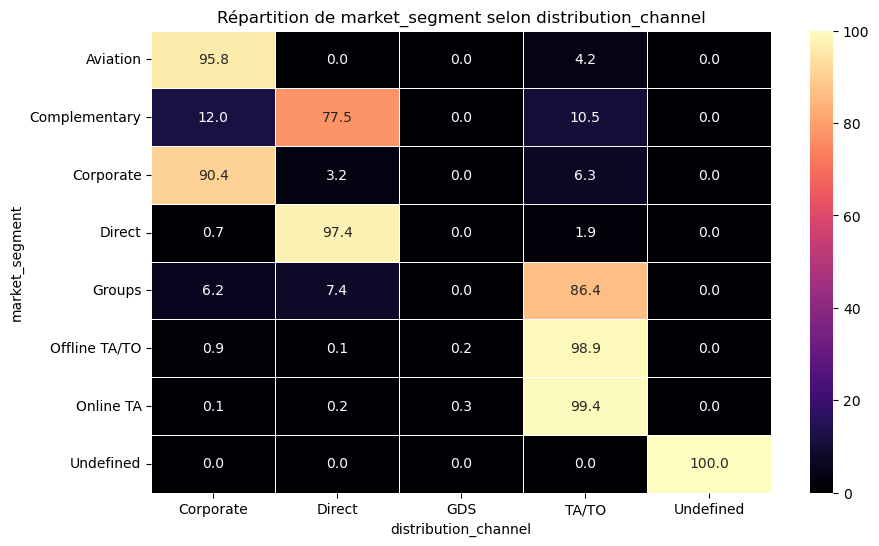

In [89]:
# Tableau croisé pour analyser la distribution conjointe
market_distribution_crosstab = pd.crosstab(hotel_df['market_segment'], hotel_df['distribution_channel'], normalize='index') * 100

# Affichage du tableau croisé
print("Répartition des `market_segment` selon `distribution_channel` (% des observations par segment) :")
display(market_distribution_crosstab)

# Visualisation avec une heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(market_distribution_crosstab, annot=True, fmt=".1f", cmap="magma", linewidths=0.5)
plt.title("Répartition de market_segment selon distribution_channel")
plt.xlabel("distribution_channel")
plt.ylabel("market_segment")
plt.show()


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">Analyse du croisement entre market_segment et distribution_channel

**Résumé des résultats**  
- Certains segments sont **quasi exclusivement** associés à un seul canal de distribution :  
  - **Aviation** → **95.8 % Corporate**  
  - **Corporate** → **90.4 % Corporate**  
  - **Direct** → **97.4 % Direct**  
  - **Offline TA/TO** → **98.9 % TA/TO**  
  - **Online TA** → **99.4 % TA/TO**  
  - **Groups** → **86.4 % TA/TO**  
  - **Complementary** → **77.5 % Direct**  
- Le canal **Undefined** est une catégorie isolée qui devra être supprimée.  

**Interprétation**  
- Il existe un **fort recouvrement** entre `market_segment` et `distribution_channel`, certains segments étant liés à un canal unique.  
- Cette forte liaison suggère une **possible redondance** entre les deux variables.  

**Décision provisoire**  
- Il est nécessaire de **quantifier cette relation** pour savoir si `distribution_channel` apporte une information supplémentaire ou non.
  
**Prochaine étape :** Calculer la **corrélation entre `market_segment` et `distribution_channel`** pour vérifier l’ampleur de leur liaison.


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">Vérification de la relation entre market_segment et distribution_channel

In [92]:
# Encodage Label Encoding pour transformer les catégories en valeurs numériques
encoder = LabelEncoder()
hotel_df["market_segment_encoded"] = encoder.fit_transform(hotel_df["market_segment"])
hotel_df["distribution_channel_encoded"] = encoder.fit_transform(hotel_df["distribution_channel"])

# Calculer la corrélation entre les deux variables
correlation = hotel_df["market_segment_encoded"].corr(hotel_df["distribution_channel_encoded"])
print(f"Corrélation entre market_segment et distribution_channel : {correlation:.4f}")


Corrélation entre market_segment et distribution_channel : 0.7678


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
     Analyse de la vérification de la relation entre market_segment et distribution_channel

Nous avons encodé les variables `market_segment` et `distribution_channel` pour mesurer leur **corrélation mutuelle.**

**Résultat :**  
**Corrélation entre `market_segment` et `distribution_channel` → 0.7678**

**Interprétation :**
- **Un score de 0.76 indique une forte corrélation** entre les deux variables.
- Cela signifie que `market_segment` et `distribution_channel` capturent **une information similaire**, ce qui suggère une potentielle redondance.
- Toutefois, une forte corrélation ne prouve pas à elle seule que l’une des variables est inutile.
  
**Conclusion provisoire :**
- Cette corrélation élevée indique qu'il pourrait être pertinent de **supprimer `distribution_channel`** pour éviter la multicolinéarité.
- **Avant toute suppression**, nous devons **confirmer statistiquement cette dépendance**.

**Prochaine étape :** Appliquer un **test du Khi² d’indépendance** pour vérifier si `market_segment` et `distribution_channel` sont statistiquement liés.  
Si le test confirme une **forte dépendance**, nous pourrons valider la suppression de `distribution_channel`.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application du test du Khi² pour market_segment et distribution_channel

In [95]:
# Création de la table de contingence (nombre d’observations pour chaque combinaison)
contingency_table_market_segment_distribution_channel = pd.crosstab(hotel_df['market_segment'], 
                                                                    hotel_df['distribution_channel'])

# Application du test du Khi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_market_segment_distribution_channel)

# Affichage des résultats
print(f"Statistique de Khi² : {chi2_stat:.4f}")
print(f"p-value : {p_value:.4e}")

# Interprétation du résultat
if p_value < 0.05:
    print("Résultat : Les variables sont dépendantes (p-value < 0.05). Il y a redondance d’information.")
else:
    print("Résultat : Les variables sont indépendantes (p-value >= 0.05). Elles apportent des informations distinctes.")

Statistique de Khi² : 228659.9223
p-value : 0.0000e+00
Résultat : Les variables sont dépendantes (p-value < 0.05). Il y a redondance d’information.


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
    Analyse des résultats du test du Khi² d’indépendance entre market_segment et distribution_channel</p>

**Nous avons effectué un test du Khi² pour évaluer la dépendance entre `market_segment` et `distribution_channel`.**  

**Résultats statistiques :**  
- **Statistique de Khi²** : 228659.9223  
- **p-value** : 0.0000e+00  

**Interprétation :**  
- La **p-value est extrêmement faible (< 0.05)**, ce qui indique une **forte dépendance statistique** entre les deux variables.
- - De plus,**la statistique de Khi² est de 228 659**, ce qui est très élevé et confirme une dépendance extrêmement forte entre `market_segment` et `distribution_channel`.
- Cela signifie que `market_segment` et `distribution_channel` **capturent en grande partie la même information**.  
- **Garder les deux pourrait introduire de la redondance** et potentiellement causer des problèmes de multicolinéarité dans les modèles prédictifs.  

**Conclusion finale :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;">Supprimer distribution_channel
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver market_segment
    
- Cette décision sera appliquée lors du **Data Preprocessing**.  

.  
   <p style="background-color:purple;color:white; font-weight:bold; font-size:17px;text-align:center;">
     Croisement deposit_type & market_segment

Répartition des `deposit_type` selon `market_segment` (% des observations par type de dépôt) :


market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
deposit_type,,,,,,,,
No Deposit,0.226489,0.710047,4.737149,12.023012,10.042909,18.357049,53.901434,0.001911
Non Refund,0.000000,0.000000,2.289710,0.130253,62.877905,34.318229,0.383903,0.000000
Refundable,0.000000,0.000000,2.469136,3.703704,80.246914,2.469136,11.111111,0.000000


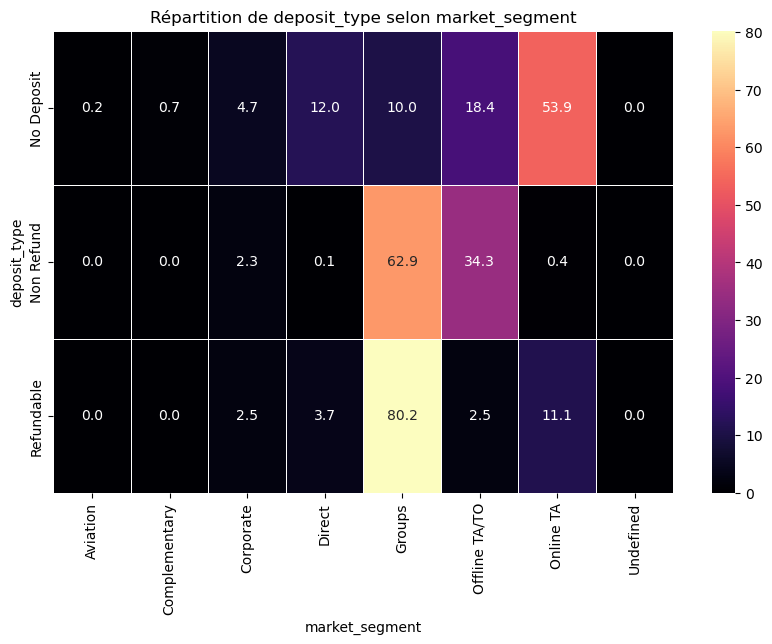

In [98]:
# Tableau croisé pour analyser la distribution conjointe
deposit_market_crosstab = pd.crosstab(hotel_df['deposit_type'], hotel_df['market_segment'], normalize='index') * 100

# Affichage du tableau croisé
print("Répartition des `deposit_type` selon `market_segment` (% des observations par type de dépôt) :")
display(deposit_market_crosstab)

# Visualisation avec un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deposit_market_crosstab, annot=True, fmt=".1f", cmap="magma", linewidths=0.5)
plt.title("Répartition de deposit_type selon market_segment")
plt.xlabel("market_segment")
plt.ylabel("deposit_type")
plt.show()


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">Analyse du croisement entre deposit_type et market_segment

**Résumé des résultats**  
- No Deposit est dominant dans Online TA (53.9 %) et Offline TA/TO (18.4 %).  
- Non Refund est majoritairement associé aux Groupes (62.9 %) et Offline TA/TO (34.3 %).  
- Refundable est principalement utilisé par les Groupes (80.2 %) et une faible part en Online TA (11.1 %).  

**Interprétation**  
- Il existe une relation forte entre `deposit_type` et `market_segment`, certaines catégories étant fortement associées à un type de dépôt spécifique.  
- Cette relation pourrait entraîner une redondance si les deux variables sont conservées simultanément dans le modèle.  
- Le type `Non Refund` est largement concentré sur les Groupes et Offline TA/TO, mais son impact sur les annulations doit être évalué.  
- Si `deposit_type` influence fortement `is_canceled`, il pourrait être plus pertinent que `market_segment` dans certains cas.  

**Décision provisoire**  
- Vérifier si `deposit_type` apporte une information supplémentaire par rapport à `market_segment` en comparant leurs corrélations avec `is_canceled`.  
- Si `deposit_type` est redondant, il faudra envisager de ne garder qu’une seule des deux variables ou de les fusionner.  

**Prochaine étape :** Comparer les corrélations de `deposit_type` et `market_segment` avec `is_canceled` pour prendre une décision.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">Influence de deposit_type et market_segment sur is_canceled

In [101]:
# Vérifier la corrélation de chaque variable avec is_canceled
corr_deposit_type = hotel_df['deposit_type'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
corr_market_segment = hotel_df['market_segment'].astype('category').cat.codes.corr(hotel_df['is_canceled'])

print(f"Corrélation deposit_type vs is_canceled : {corr_deposit_type:.4f}")
print(f"Corrélation market_segment vs is_canceled : {corr_market_segment:.4f}")

Corrélation deposit_type vs is_canceled : 0.4686
Corrélation market_segment vs is_canceled : 0.0593


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
Analyse de l'influence de deposit_type et market_segment sur is_canceled


**Comparaison des corrélations avec is_canceled**  
- Corrélation `deposit_type` vs `is_canceled` : **0.4686**  
- Corrélation `market_segment` vs `is_canceled` : **0.0593**  

**Interprétation**  
- `deposit_type` présente une corrélation bien plus forte avec `is_canceled`, suggérant qu'il joue un rôle majeur dans la prédiction des annulations.  
- À l’inverse, `market_segment` a une corrélation très faible, ce qui indique qu’il pourrait avoir un impact limité sur les annulations.  
- Cette différence montre que `deposit_type` capture une information plus pertinente que `market_segment` concernant les comportements d’annulation.  

**Décision provisoire**  
- `deposit_type` semble être une variable clé à conserver pour la modélisation.  
- `market_segment`, avec sa faible corrélation, pourrait être moins pertinent et éventuellement supprimé.  
- Avant toute suppression, il faudra vérifier s'il contient tout de même des informations complémentaires non couvertes par `deposit_type`.  

**Prochaine étape**  
- Appliquer un **test du Khi² d’indépendance** pour vérifier si `deposit_type` et `market_segment` sont statistiquement liés.  
Si le test confirme une **forte dépendance**, nous pourrons valider la suppression de `market_segment`.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application du test du Khi² pour deposit_type et market_segment

In [104]:
# Création de la table de contingence (nombre d’observations pour chaque combinaison)
contingency_table_deposit_type_market_segment = pd.crosstab(hotel_df['deposit_type'], hotel_df['market_segment'])

# Application du test du Khi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_deposit_type_market_segment)

# Affichage des résultats
print(f"Statistique de Khi² : {chi2_stat:.4f}")
print(f"p-value : {p_value:.4e}")

# Interprétation du résultat
if p_value < 0.05:
    print("Résultat : Les variables sont dépendantes (p-value < 0.05). Il y a redondance d’information.")
else:
    print("Résultat : Les variables sont indépendantes (p-value >= 0.05). Elles apportent des informations distinctes.")

Statistique de Khi² : 33397.9120
p-value : 0.0000e+00
Résultat : Les variables sont dépendantes (p-value < 0.05). Il y a redondance d’information.


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
    Analyse des résultats du test du Khi² d’indépendance entre deposit_type et market_segment</p>

**Nous avons effectué un test du Khi² pour évaluer la dépendance entre `deposit_type` et `market_segment`.**  

**Résultats statistiques :**  
- **Statistique de Khi²** : 33 397.9120  
- **p-value** : 0.0000e+00  

**Interprétation :**  
- La **p-value est extrêmement faible (< 0.05)**, ce qui indique une **forte dépendance statistique** entre les deux variables.
- De plus, **la statistique de Khi² est de 33 397** *(même si moins forte que celle du croisement market_segment et distribution_channel)* montrant une dépendance encore plus marquée que dans le premier cas.
- Cela signifie que `deposit_type` et `market_segment` **capturent en grande partie la même information**.  
- **Garder les deux pourrait introduire de la redondance** et potentiellement causer des problèmes de multicolinéarité dans les modèles prédictifs.  

**Conclusion finale :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;">Supprimer market_segment</p>
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver deposit_type</p>

- Cette décision sera appliquée lors du **Data Preprocessing**.  


.  
   <p style="background-color:purple;color:white; font-weight:bold; font-size:17px;text-align:center;">
     Croisement deposit_type & customer_type

Répartition des `deposit_type` selon `customer_type` (% des observations par type de dépôt) :


customer_type,Contract,Group,Transient,Transient-Party
deposit_type,,,,
No Deposit,3.373439,0.543764,73.282939,22.799859
Non Refund,3.729348,0.000000,88.496607,7.774045
Refundable,1.234568,4.938272,12.345679,81.481481


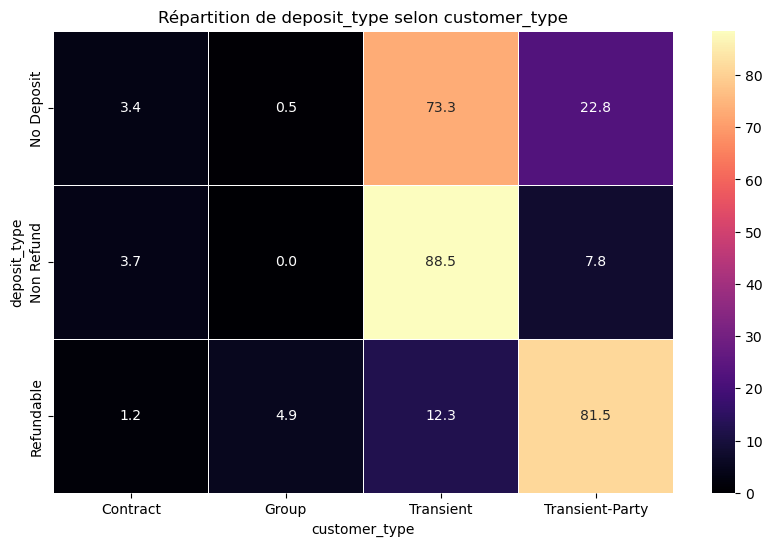

In [107]:
# Tableau croisé pour analyser la distribution conjointe
deposit_customer_crosstab = pd.crosstab(hotel_df['deposit_type'], hotel_df['customer_type'], normalize='index') * 100

# Affichage du tableau croisé
print("Répartition des `deposit_type` selon `customer_type` (% des observations par type de dépôt) :")
display(deposit_customer_crosstab)

# Visualisation avec un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deposit_customer_crosstab, annot=True, fmt=".1f", cmap="magma", linewidths=0.5)
plt.title("Répartition de deposit_type selon customer_type")
plt.xlabel("customer_type")
plt.ylabel("deposit_type")
plt.show()

<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
Analyse du croisement entre deposit_type et customer_type</p>

**Résumé des résultats**  
- **No Deposit** est dominant chez les **clients Transient (73.3 %)**, suivi des **clients Transient-Party (22.8 %)**.  
- **Non Refund** est **majoritairement utilisé par les clients Transient (88.5 %)**, avec une part plus faible chez les **clients Transient-Party (7.8 %)**.  
- **Refundable** est **principalement associé aux clients Transient-Party (81.5 %)**, tandis que les autres catégories en utilisent très peu.  

**Interprétation**  
- Il existe une **relation forte entre `deposit_type` et `customer_type`**, certaines catégories étant fortement associées à un type de dépôt spécifique.  
- **Les clients Transient utilisent massivement No Deposit et Non Refund**, tandis que les **clients Transient-Party privilégient Refundable**.  
- **Les clients Group et Contract sont très minoritaires**, ce qui peut limiter leur impact dans l’analyse.  
- Cette dépendance pourrait entraîner une **redondance** si les deux variables sont conservées simultanément dans le modèle.  

**Décision provisoire**  
- Vérifier si `deposit_type` et `customer_type` apportent **une information complémentaire** ou s’ils sont redondants en comparant leurs **corrélations avec `is_canceled`**.  
- Si `customer_type` est peu corrélé à `is_canceled`, alors `deposit_type` pourrait suffire à expliquer le comportement d’annulation.  

**Prochaine étape :** Comparer les **corrélations de `deposit_type` et `customer_type` avec `is_canceled`** pour prendre une décision.  

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">Influence de deposit_type et customer_type sur is_canceled

In [110]:
# Vérifier la corrélation de chaque variable avec is_canceled
corr_deposit_type = hotel_df['deposit_type'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
corr_customer_type = hotel_df['customer_type'].astype('category').cat.codes.corr(hotel_df['is_canceled'])

print(f"Corrélation deposit_type vs is_canceled : {corr_deposit_type:.4f}")
print(f"Corrélation customer_type vs is_canceled : {corr_customer_type:.4f}")

Corrélation deposit_type vs is_canceled : 0.4686
Corrélation customer_type vs is_canceled : -0.0681


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
Analyse de l'influence de deposit_type et customer_type sur is_canceled

**Comparaison des corrélations avec is_canceled**  
- **Corrélation `deposit_type` vs `is_canceled` : 0.4686**  
- **Corrélation `customer_type` vs `is_canceled` : -0.0681**  

**Interprétation**  
- `deposit_type` présente une **corrélation forte et positive avec is_canceled**, indiquant que cette variable joue un **rôle majeur** dans la prédiction des annulations.  
- `customer_type` a une **corrélation très faible et négative**, suggérant qu’il a un impact **quasiment négligeable** sur les annulations.  
- Cette différence montre que `deposit_type` est une variable **clairement plus pertinente** que `customer_type` pour prédire `is_canceled`.  

**Décision provisoire**  
- Puisque `deposit_type` a une **forte influence** et que `customer_type` semble **moins pertinent**, il est nécessaire de vérifier si `customer_type` apporte **une information complémentaire**.  


**Prochaine étape** : Appliquer un **test du Khi² d’indépendance** entre `deposit_type` et `customer_type` pour évaluer leur redondance.  
**Si elles sont dépendantes** → Il pourrait être pertinent de **supprimer `customer_type`**.  
 **Si elles sont indépendantes** → `customer_type` capture une information unique et peut être conservé.  


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application du test du Khi² pour deposit_type et customer_type

In [113]:
# Création de la table de contingence (nombre d’observations pour chaque combinaison)
contingency_table_deposit_type_customer_type = pd.crosstab(hotel_df['deposit_type'], hotel_df['customer_type'])

# Application du test du Khi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_deposit_type_customer_type)

# Affichage des résultats
print(f"Statistique de Khi² : {chi2_stat:.4f}")
print(f"p-value : {p_value:.4e}")

# Interprétation du résultat
if p_value < 0.05:
    print("Résultat : Les variables sont dépendantes (p-value < 0.05). Il y a redondance d’information.")
else:
    print("Résultat : Les variables sont indépendantes (p-value >= 0.05). Elles apportent des informations distinctes.")

Statistique de Khi² : 2286.8608
p-value : 0.0000e+00
Résultat : Les variables sont dépendantes (p-value < 0.05). Il y a redondance d’information.


<p style="background-color:pink; color:black; font-weight:bold;text-align:center;">
    Analyse des résultats du test du Khi² d’indépendance entre deposit_type et customer_type</p>

**Nous avons effectué un test du Khi² pour évaluer la dépendance entre `deposit_type` et `customer_type`.**  

**Résultats statistiques :**  
- **Statistique de Khi²** : 2 286.8608  
- **p-value** : 0.0000e+00  

**Interprétation**  
- La **p-value est extrêmement faible (< 0.05)**, ce qui indique une **forte dépendance statistique** entre les deux variables.  
- De plus, **la statistique de Khi² est de 2 286**, ce qui montre une dépendance marquée, bien que moins forte que dans d'autres croisements analysés.  
- Cela signifie que `deposit_type` et `customer_type` **capturent en partie la même information**, suggérant une possible redondance.  
- **Garder les deux variables pourrait introduire une duplication d’information**, ce qui pourrait nuire à l’efficacité du modèle prédictif.  

**Conclusion finale :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;">Supprimer market_segment</p>
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver deposit_type</p>

- Cette décision sera appliquée lors du **Data Preprocessing**.



### **4.2.4 Récapitulatif des décisions sur les transformations à appliquer (variables catégorielles)**

 <p style="background-color:purple;color:white; font-weight:bold; font-size:18px;text-align:center;">    
    Récapitulatif des variables catégorielles significatives et transformations à appliquer

**Variables catégorielles significatives identifiées**  
Nous avons sélectionné les **variables catégorielles les plus pertinentes** pour expliquer `is_canceled`.  
L’analyse de leur **distribution**, de leurs **relations avec is_canceled**, ainsi que des **tests de dépendance (Khi²)** nous a permis de déterminer les transformations nécessaires avant leur utilisation en modélisation.  
  
.  
**Liste des variables catégorielles significatives :**  
| **Variable** | **Observations** | **Problèmes identifiés** |
|-------------|-----------------|---------------------------|
| `hotel` | Deux catégories bien distinctes (`City Hotel`, `Resort Hotel`) | Aucune transformation nécessaire |
| `meal` | Forte dominance de `BB`, autres catégories peu fréquentes | Nécessité de vérifier leur impact sur `is_canceled` |
| `country_grouped` | Présence d’un regroupement basé sur la fréquence des pays | Vérification de la pertinence du regroupement |
| `market_segment` | Forte dépendance avec `deposit_type` et `customer_type` | Redondance confirmée (test Khi²) |
| `distribution_channel` | Fortement lié à `market_segment` | Redondance confirmée (test Khi²) |
| `deposit_type` | Forte corrélation avec `is_canceled` (+0.4686) | Aucune transformation nécessaire |
| `customer_type` | Dépendant de `deposit_type`, mais apportant une information complémentaire | Aucune transformation nécessaire |
  
.  
**Transformations prévues pour la modélisation**  
Certaines variables nécessitent des transformations avant leur utilisation dans un modèle.  
Les décisions ont été prises en fonction des **analyses de distribution**, des **relations avec is_canceled**, et des **tests Khi²**.

| **Variable** | **Transformation à appliquer** | **Justification** |
|-------------|------------------------------|-------------------|
| `hotel` | **Label Encoding** | Variable binaire directement exploitable |
| `meal` | **Label Encoding** | Les taux d’annulation ne suivent pas la distribution des catégories, chaque modalité semble apporter une information pertinente |
| `country_grouped` | **Conserver le regroupement  / One-Hot Encoding** | Le regroupement basé sur la fréquence des pays est pertinent et a été validé |
| `market_segment` | **Suppression** | Fortement redondant avec `deposit_type` et `customer_type` (confirmé par Khi²) |
| `distribution_channel` | **Suppression** | Redondance avec `market_segment`, confirmé par Khi² |
| `deposit_type` | **Label Encoding** | Forte corrélation avec `is_canceled`, apporte une information clé |
| `customer_type` | **Label Encoding** | Malgré sa dépendance avec `deposit_type`, il apporte une information complémentaire |

.  
**Transition vers le Data Preprocessing**  
Afin de conserver une **séparation stricte entre l’EDA et le Data Preprocessing**, **aucune transformation n’est appliquée ici**.  
Toutes les modifications mentionnées ci-dessus seront mises en œuvre **dans la partie Data Preprocessing**, où leur impact sur la distribution des variables et la performance du modèle sera validé.


## **4.3 Identification des Effets Temporels sur les Annulations**

### **4.3.1 Identification des variables Datetime significatives**

.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Identification des variables datetime du dataset


In [120]:
# Sélectionner uniquement les colonnes  datetime64[ns]
datetime64_cols = hotel_df.select_dtypes(include='datetime64[ns]').columns

# Afficher la liste des colonnes datetime64
print("Variables datetime64 dans le dataset :")
print(datetime64_cols)


Variables datetime64 dans le dataset :
Index(['reservation_status_date', 'arrival_datetime'], dtype='object')


.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de reservation_status_date sur is_canceled

Le problème pour analyser reservation_status_date est qu'**il y a énormément de catégories (date)** ce qui rendrait l'analyse illisible si on affichait toutes les valeurs.  
Mais il nous est possible de regrouper ces dates par mois et années *(au format YYYY-MM)* afin de faciliter la lecture.   
***Solution : Créer `reservation_status_month` pour regrouper les dates par mois et année (YYYY-MM)***

Nombre de réservations par mois du dernier statut de réservation :
 reservation_status_month
2014-10     180
2014-11       1
2015-01     948
2015-02      44
2015-03      85
2015-04     151
2015-05     275
2015-06     666
2015-07    3615
2015-08    3247
2015-09    4017
2015-10    5742
2015-11    3077
2015-12    3062
2016-01    4482
2016-02    4596
2016-03    5319
2016-04    5214
2016-05    5023
2016-06    4552
2016-07    4453
2016-08    4585
2016-09    4993
2016-10    5221
2016-11    5021
2016-12    4338
2017-01    5251
2017-02    4858
2017-03    4826
2017-04    4634
2017-05    5006
2017-06    4060
2017-07    4038
2017-08    3417
2017-09     393
Name: count, dtype: int64

Taux d’annulation par mois du dernier statut de réservation :


,Confirmé,Annulé
reservation_status_month,,
2014-10,0.000000,100.000000
2014-11,0.000000,100.000000
2015-01,0.000000,100.000000
2015-02,0.000000,100.000000
2015-03,0.000000,100.000000
2015-04,0.000000,100.000000
2015-05,0.000000,100.000000
2015-06,0.000000,100.000000
2015-07,36.542185,63.457815


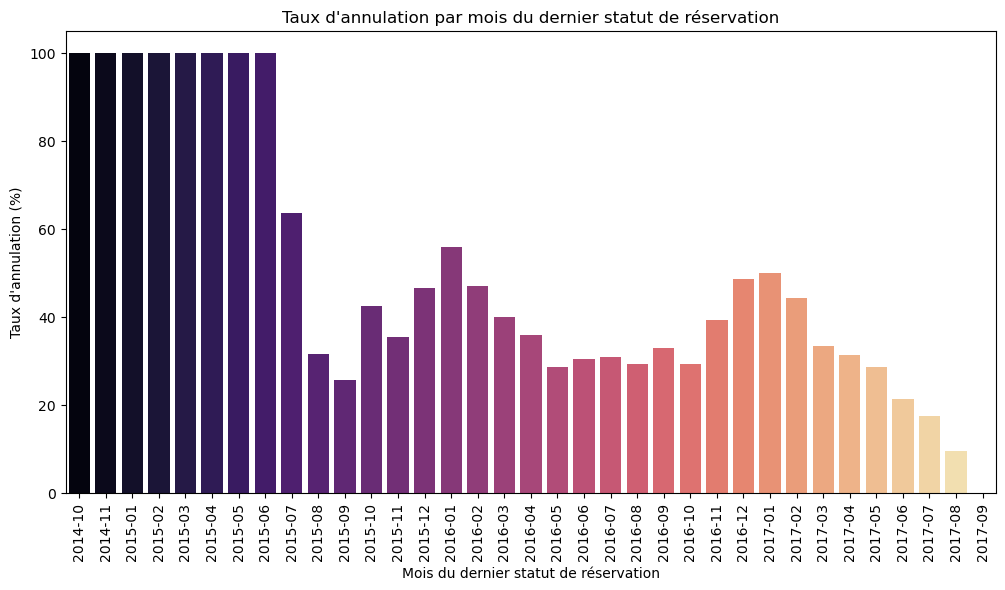

Corrélation `reservation_status_month` vs `is_canceled` : -0.1639


In [122]:
# Extraire l'année et le mois au format YYYY-MM
hotel_df['reservation_status_month'] = hotel_df['reservation_status_date'].dt.to_period('M').astype(str)

# Compter le nombre de réservations par mois
reservation_status_month_counts = hotel_df['reservation_status_month'].value_counts().sort_index()
print("Nombre de réservations par mois du dernier statut de réservation :\n", reservation_status_month_counts)

# Calcul du taux d’annulation par mois
reservation_status_month_analysis = pd.crosstab(hotel_df['reservation_status_month'], hotel_df['is_canceled'], normalize='index') * 100
reservation_status_month_analysis.columns = ['Confirmé', 'Annulé']
reservation_status_month_analysis = reservation_status_month_analysis.sort_index()

# Affichage du tableau des taux d'annulation
print("\nTaux d’annulation par mois du dernier statut de réservation :")
display(reservation_status_month_analysis)

# Barplot des taux d'annulation par mois
plt.figure(figsize=(12, 6))
sns.barplot(x=reservation_status_month_analysis.index, y=reservation_status_month_analysis['Annulé'], 
            hue=reservation_status_month_analysis.index ,palette='magma', legend=False)
plt.title("Taux d'annulation par mois du dernier statut de réservation")
plt.xlabel("Mois du dernier statut de réservation")
plt.ylabel("Taux d'annulation (%)")
plt.xticks(rotation=90)
plt.show()

#Test de la corrélation reservation_status_month avec is_canceled
corr_reservation_status = hotel_df['reservation_status_month'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
print(f"Corrélation `reservation_status_month` vs `is_canceled` : {corr_reservation_status:.4f}")

 <p style="background-color:DarkKhaki; color:black; font-weight:bold;text-align:center;">
Analyse du taux d’annulation par mois du dernier statut de réservation  

L’analyse des annulations selon le mois du dernier statut de réservation montre **une tendance temporelle marquée**.

**Observations principales :**  
- **Les taux d’annulation fluctuent considérablement selon la période**, indiquant une **influence du facteur temps** sur les comportements d’annulation.  
- **Avant juillet 2015, le taux d’annulation est systématiquement de 100 %**, suggérant des données incomplètes ou un biais dans la collecte pour ces périodes.  
- **Entre juillet 2015 et août 2017, les taux d’annulation diminuent progressivement**, atteignant **9.36 % en août 2017**.  
- **En septembre 2017, 100 % des réservations ont été confirmées**, ce qui pourrait refléter une période de faible activité ou un problème dans les données.
- **La corrélation entre `reservation_status_month` et `is_canceled` est faible (-0.1639)**, indiquant que d’autres facteurs influencent aussi les annulations. 

**Interprétation :**  
- **L’effet temporel joue un rôle dans les annulations, mais il reste modéré.**
- **Les données avant juillet 2015 et après août 2017 ne semblent pas représentatives** et pourraient introduire du bruit dans l’analyse.  
- **L’analyse de la distribution de `reservation_status_month` est nécessaire** afin de détecter des anomalies éventuelles et d’affiner les transformations à appliquer.

**Conclusion :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;"> reservation_status_month est une variable significative.  

- **L’effet temporel influence les annulations**, mais la corrélation (-0.1639) montre que ce n’est pas le seul facteur clé.
- **Une analyse approfondie de sa distribution est nécessaire** avant d’appliquer toute transformation.
- **Les périodes avant juillet 2015 et après août 2017 devront être examinées** pour confirmer leur exclusion.

.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Analyse de l’impact de arrival_datetime  sur is_canceled

Comme pour analyser reservation_status_date, le problème pour arrival_datetime est qu'**il y a énormément de catégories (date)** ce qui rend l'analyse illisible si on affichait toutes les valeurs.  
Nous allons donc regrouper ces dates par mois et années *(au format YYYY-MM)* afin de faciliter la lecture.   
***Solution : Créer arrival_month_year pour regrouper les dates par mois et année (YYYY-MM)***

Nombre de réservations par mois d'arrivée :
 arrival_month_year
2015-07    2776
2015-08    3889
2015-09    5114
2015-10    4957
2015-11    2340
2015-12    2920
2016-01    2248
2016-02    3891
2016-03    4824
2016-04    5428
2016-05    5478
2016-06    5292
2016-07    4572
2016-08    5063
2016-09    5394
2016-10    6203
2016-11    4454
2016-12    3860
2017-01    3681
2017-02    4177
2017-03    4970
2017-04    5661
2017-05    6313
2017-06    5647
2017-07    5313
2017-08    4925
Name: count, dtype: int64

Taux d’annulation par mois d'arrivée :


,Confirmé,Annulé
arrival_month_year,,
2015-07,54.646974,45.353026
2015-08,58.909745,41.090255
2015-09,59.053578,40.946422
2015-10,65.059512,34.940488
2015-11,79.230769,20.769231
2015-12,66.678082,33.321918
2016-01,75.222420,24.777580
2016-02,65.638653,34.361347
2016-03,69.382255,30.617745


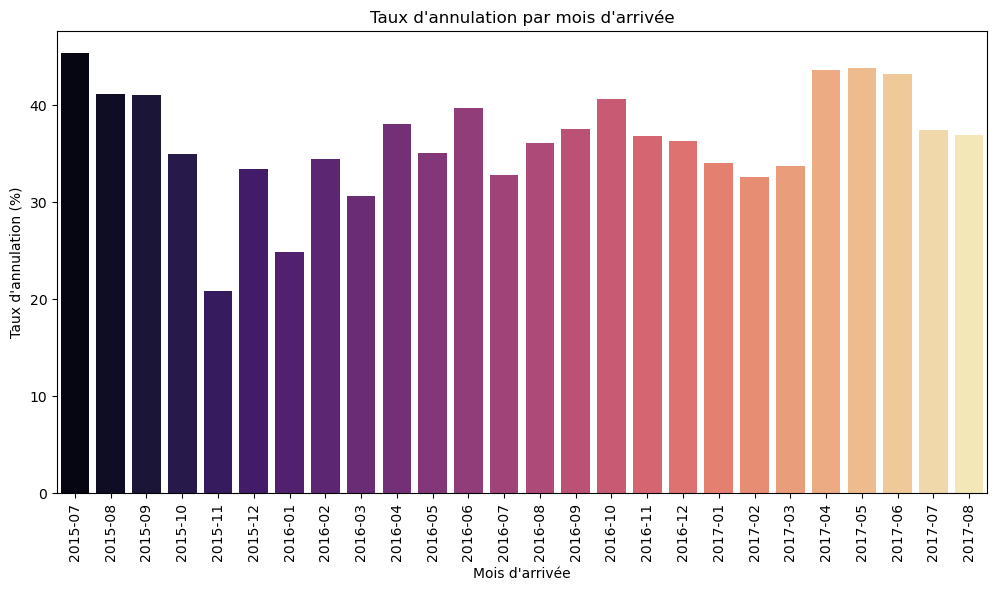

Corrélation `arrival_month_year` vs `is_canceled` : 0.0239


In [125]:
# Extraire l'année et le mois au format YYYY-MM
hotel_df['arrival_month_year'] = hotel_df['arrival_datetime'].dt.to_period('M').astype(str)

# Compter le nombre de réservations par mois d'arrivée
arrival_month_counts = hotel_df['arrival_month_year'].value_counts().sort_index()
print("Nombre de réservations par mois d'arrivée :\n", arrival_month_counts)

# Calcul du taux d’annulation par mois d'arrivée
arrival_month_analysis = pd.crosstab(hotel_df['arrival_month_year'], hotel_df['is_canceled'], normalize='index') * 100
arrival_month_analysis.columns = ['Confirmé', 'Annulé']
arrival_month_analysis = arrival_month_analysis.sort_index()

# Affichage du tableau des taux d'annulation
print("\nTaux d’annulation par mois d'arrivée :")
display(arrival_month_analysis)

plt.figure(figsize=(12, 6))
sns.barplot(x=arrival_month_analysis.index, y=arrival_month_analysis['Annulé'], 
            hue=arrival_month_analysis.index, palette='magma', legend=False)
plt.title("Taux d'annulation par mois d'arrivée")
plt.xlabel("Mois d'arrivée")
plt.ylabel("Taux d'annulation (%)")
plt.xticks(rotation=90)
plt.show()

#Test de la corrélation arrival_month_year avec is_canceled
corr_arrival_month = hotel_df['arrival_month_year'].astype('category').cat.codes.corr(hotel_df['is_canceled'])
print(f"Corrélation `arrival_month_year` vs `is_canceled` : {corr_arrival_month:.4f}")

<p style="background-color:DarkKhaki; color:black; font-weight:bold;text-align:center;">
Analyse du taux d’annulation par mois d’arrivée  

L’analyse des annulations selon le mois d’arrivée permet d’observer **d’éventuelles variations temporelles sur les comportements d’annulation**.

**Observations principales :**  
- **Les taux d’annulation varient légèrement selon les mois**, mais sans tendance claire ni saisonnalité marquée.  
**Aucune période ne se distingue par un taux d’annulation nettement plus élevé ou plus bas que les autres.**
- **La corrélation entre `arrival_month_year` et `is_canceled` est extrêmement faible (0.0239)**, ce qui indique une absence de lien significatif entre ces deux variables.  

**Interprétation :**  
- **Contrairement à `reservation_status_month`, `arrival_month_year` n’a pas d’impact clair sur les annulations.**  
- **La très faible corrélation suggère que les décisions d’annulation ne dépendent pas du mois d’arrivée des clients.**  
- **L’effet temporel observé sur les annulations est probablement mieux capturé par d’autres variables, comme `reservation_status_month`.**
 
**Conclusion :**  
<p style="background-color:lightcoral; color:black; font-weight:bold;"> 
    arrival_month_year n’est pas une variable significative.  
    
- **L’absence de corrélation et de tendance temporelle évidente justifie son exclusion de l’analyse prédictive.**  
- **Sa suppression sera envisagée lors du Data Preprocessing pour éviter d’introduire du bruit dans le modèle.**  


### **4.3.2 Distribution des variables Datetime significatives**

.  
<p style="background-color:DarkGreen; color:white; font-weight:bold;text-align:center;">Analyse de la distribution de reservation_status_month

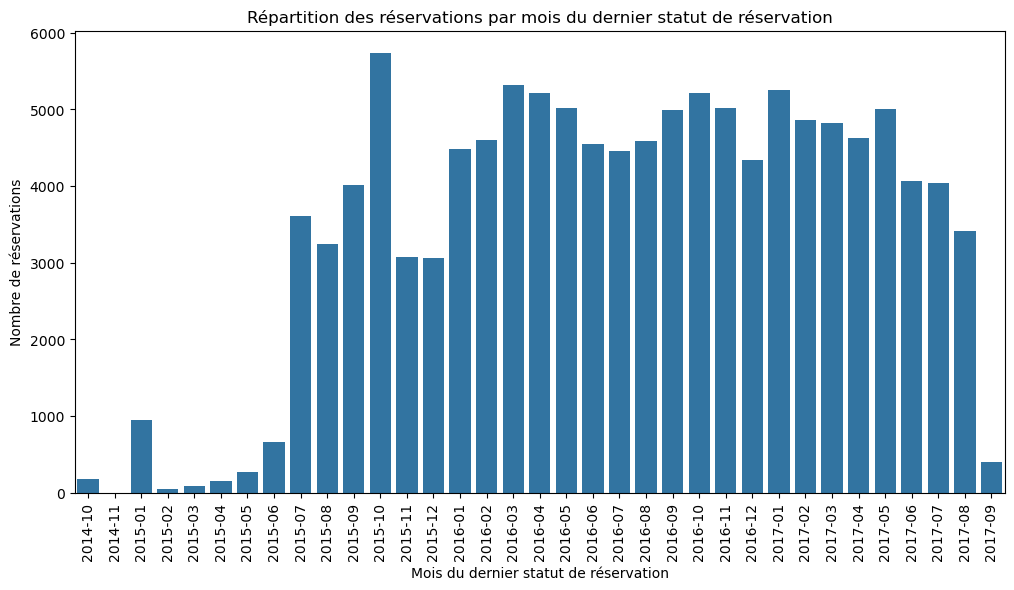

In [129]:
# Vérifier la distribution de reservation_status_month avec tri chronologique
plt.figure(figsize=(12,6))
sns.countplot(x=hotel_df['reservation_status_month'], 
              order=sorted(hotel_df['reservation_status_month'].unique()))  # Trier par ordre chronologique
plt.title("Répartition des réservations par mois du dernier statut de réservation")
plt.xlabel("Mois du dernier statut de réservation")
plt.ylabel("Nombre de réservations")
plt.xticks(rotation=90)
plt.show()


 <p style="background-color:DarkKhaki; color:black; font-weight:bold;text-align:center;">
Analyse de la distribution de reservation_status_month

Nous analysons la **distribution** de `reservation_status_month` afin de :  
- **Détecter d’éventuelles anomalies** (périodes avec très peu ou beaucoup de réservations).  
- **Confirmer la saisonnalité observée dans les annulations**.  
- **S’assurer que la plage temporelle retenue est cohérente** pour l’analyse des annulations.  

**Observations principales :**  
- **La majorité des réservations est concentrée entre juillet 2015 et août 2017**, avec un pic maximal en **octobre 2015**.  
- **Les périodes de début (octobre 2014 - juin 2015) et de fin (septembre 2017) montrent un volume extrêmement faible**.  
  - Cela suggère **une montée en charge progressive** de la collecte des données et une **baisse brutale après août 2017**.
  -   - **Ces périodes sont potentiellement biaisées et non représentatives.**  
- **L’analyse confirme que les réservations entre juillet 2015 et août 2017 sont les plus fiables** pour une étude robuste des annulations.  

**Interprétation :**  
- **La répartition des données dans le temps est inégale**, ce qui pourrait introduire du bruit si toutes les périodes sont conservées sans ajustement.  
- **Les données avant mi-2015 et après août 2017 ne sont pas représentatives et doivent être exclues.**
- **Le format actuel de `reservation_status_month` (YYYY-MM) est pertinent** et permet de capturer correctement les tendances temporelles sans nécessiter d’autres transformations. 

**Conclusion finale :**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">Conserver reservation_status_month  et exclure certaines périodes.  

- **Exclusions à effectuer :**
    - **Supprimer les observations avant juillet 2015 et après août 2017**

- **Le format `YYYY-MM` sera conservé tel quel.**
- Cette décision sera appliquée lors du **Data Preprocessing**. 

### **4.3.3 Récapitulatif des décisions sur les transformations à appliquer (variables Datetime)**

<p style="background-color:DarkKhaki;color:black; font-weight:bold; font-size:18px;text-align:center;">    
    Récapitulatif des variables datetime significatives et transformations à appliquer</p>

**Variables datetime significatives identifiées**  
Nous avons analysé l’impact de `reservation_status_date` et `arrival_datetime` sur `is_canceled` afin de déterminer leur importance dans la modélisation.  
L’analyse de leur **distribution**, des **fluctuations des taux d’annulation dans le temps**, ainsi que des **anomalies de collecte de données** nous a permis de définir les transformations nécessaires.  

**Liste des variables datetime significatives :**  

| **Variable** | **Observations** | **Problèmes identifiés** |
|-------------|-----------------|---------------------------|
| `reservation_status_month` | Fort lien temporel avec `is_canceled` et Version agrégée de `reservation_status_date` (format YYYY-MM) | Périodes sous-représentées en début et fin de dataset, nécessitant une prise de décision |

**Transformations prévues pour la modélisation**  
Les décisions ont été prises en fonction des **fluctuations temporelles des taux d’annulation**, des **problèmes de granularité excessive**, et de la nécessité d’optimiser les variables temporelles.

| **Variable** | **Transformation à appliquer** | **Justification** |
|-------------|------------------------------|-------------------|
| `reservation_status_month` | **Exclure les périodes biaisées (avant 2015-07 et après 2017-08)** | Représente bien l’évolution temporelle des annulations |


**Transition vers le Data Preprocessing**  
Afin de conserver une **séparation stricte entre l’EDA et le Data Preprocessing**, **aucune transformation n’est appliquée ici**.  
Les transformations définies ci-dessus seront mises en œuvre **dans la partie Data Preprocessing**, où leur impact sur l’analyse et la performance du modèle sera validé.


## **4.4 Récapitulatif des décisions des transformations à appliquer dans le Data Preprocessing**

<p style="background-color:LightSeaGreen;color:white; font-weight:bold; font-size:20px;text-align:center;">    
Synthèse des décisions sur les transformations à appliquer dans le Data Preprocessing  

**Variables significatives identifiées**  
Nous avons sélectionné les **variables numériques, catégorielles et datetime les plus pertinentes** pour expliquer `is_canceled`.  
L’analyse des **corrélations (Pearson)**, des **tests de dépendance (Khi²)** et des **distributions** a permis d’identifier ces variables et de définir les transformations nécessaires avant leur intégration dans un modèle prédictif.  

.    
**Transformations prévues pour la modélisation**  
| **Type de Variable** | **Variable** | **Transformation à appliquer** | **Justification** |
|-------------|-------------|------------------------------|-------------------|
| Numérique | `lead_time` | **Transformation logarithmique** | Réduire l’impact des valeurs extrêmes |
| Numérique | `previous_cancellations` | **Binarisation (`0 = jamais annulé`, `1 = au moins une annulation`)** | La plupart des valeurs sont 0, peu de variance au-delà de 1 |
| Numérique | `booking_changes` | **Capping à 3** | Éviter l’impact des valeurs très rares supérieures à 3 |
| Numérique | `required_car_parking_spaces` | **Binarisation (`0 = aucune place`, `1+ = au moins une place demandée`)** | La quasi-totalité des valeurs >1 sont rares et peu significatives |
| Numérique | `total_of_special_requests` | **Conserver tel quel, mais tester un capping à 3 après analyse de l’impact sur la distribution** | Vérifier si les valeurs élevées influencent `is_canceled` |
| Catégorielle | `hotel` | **Label Encoding** | Variable binaire directement exploitable |
| Catégorielle | `meal` | **Label Encoding** | Les taux d’annulation ne suivent pas la distribution des catégories, chaque modalité semble apporter une information pertinente |
| Catégorielle | `country_grouped` | **Conserver le regroupement  / One-Hot Encoding** | Le regroupement basé sur la fréquence des pays est pertinent et a été validé |
| Catégorielle | `market_segment` | **Suppression** | Fortement redondant avec `deposit_type` et `customer_type` (confirmé par Khi²) |
| Catégorielle | `distribution_channel` | **Suppression** | Redondance avec `market_segment`, confirmé par Khi² |
| Catégorielle | `deposit_type` | **Label Encoding** | Forte corrélation avec `is_canceled`, apporte une information clé |
| Catégorielle | `customer_type` | **Label Encoding** | Malgré sa dépendance avec `deposit_type`, il apporte une information complémentaire |
| Datetime | `reservation_status_date` | **Suppression** | Trop de valeurs uniques, peu exploitable en l’état |
| Datetime | `reservation_status_month` | **Conserver avec exclusion des périodes biaisées (avant 2015-07 et après 2017-08)** | Représente bien l’évolution temporelle des annulations |
| Datetime | `arrival_datetime` | **Suppression** | Redondance avec d’autres variables et trop granulaire |
| Datetime | `arrival_month_year` | **Suppression** | Faible corrélation avec is_canceled et aucune amélioration du modèle observée dans les tests |

>Note : *L’encodage est nécessaire car **les modèles de Machine Learning ne traitent que des valeurs numériques.***  
> Deux méthodes sont utilisées :  
***One-Hot Encoding (OHE)** → crée une colonne binaire par catégorie, adapté aux variables sans hiérarchie (hotel, meal, country_grouped).*  
***Label Encoding** → attribue un numéro unique à chaque catégorie, adapté aux variables avec peu de modalités (deposit_type, customer_type).*

.  
**Transition vers le Data Preprocessing**  
Afin de conserver une **séparation stricte entre l’EDA et le Data Preprocessing**, **aucune transformation n’est appliquée ici**.  
Toutes les modifications mentionnées ci-dessus seront mises en œuvre **dans la partie Data Preprocessing**, où leur impact sur la distribution des variables et la performance du modèle sera validé.  
.  
  
**Prochaine étape :** Appliquer ces transformations dans la section **5 Data Preprocessing**.


# **5- Data Preprocessing**

## **5.1 Préparation des Variables Numériques**

### **5.1.1 Application des transformations des variables numériques**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application la transformation logarithmique à lead_time


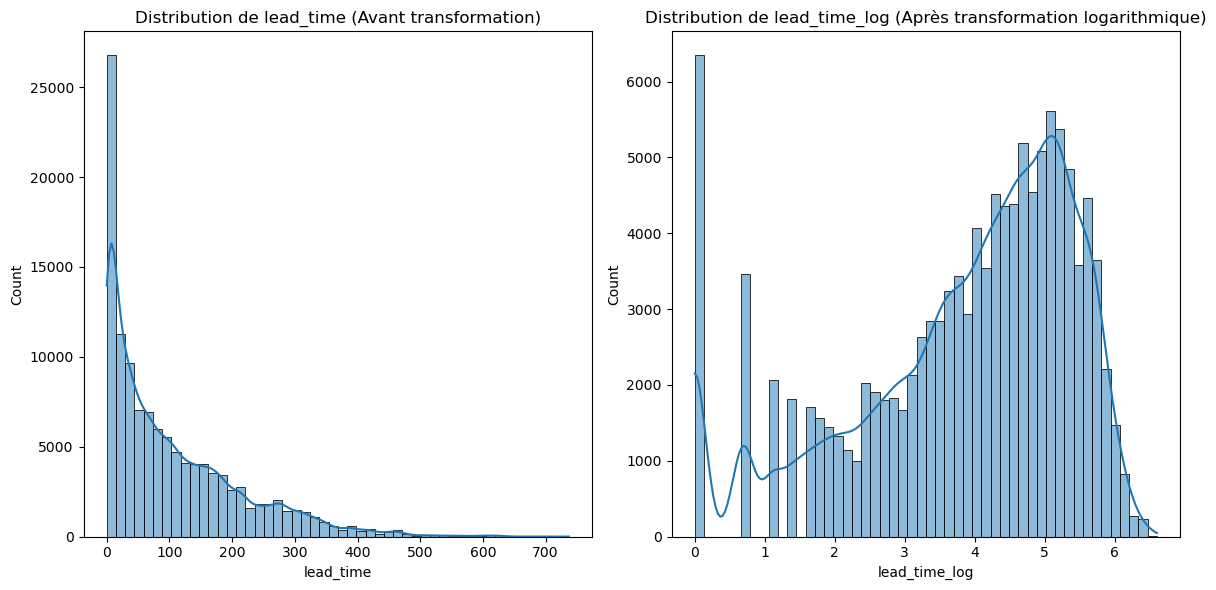


Corrélation lead_time vs is_canceled : 0.2931
Corrélation lead_time_log vs is_canceled : 0.3201


In [139]:
# Création d'une nouvelle colonne transformée
hotel_df["lead_time_log"] = np.log1p(hotel_df["lead_time"])

# Vérification de la transformation
hotel_df[["lead_time", "lead_time_log"]].describe()

plt.figure(figsize=(12, 6))
# Histogramme de lead_time AVANT transformation
plt.subplot(1, 2, 1)
sns.histplot(hotel_df["lead_time"], bins=50, kde=True)
plt.title("Distribution de lead_time (Avant transformation)")

# Histogramme de lead_time APRÈS transformation logarithmique
plt.subplot(1, 2, 2)
sns.histplot(hotel_df["lead_time_log"], bins=50, kde=True)
plt.title("Distribution de lead_time_log (Après transformation logarithmique)")

plt.tight_layout()
plt.show()


# Comparaison des corrélations avec is_canceled
corr_original = hotel_df["lead_time"].corr(hotel_df["is_canceled"])
corr_transformed = hotel_df["lead_time_log"].corr(hotel_df["is_canceled"])

print(f"\nCorrélation lead_time vs is_canceled : {corr_original:.4f}")
print(f"Corrélation lead_time_log vs is_canceled : {corr_transformed:.4f}")


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;"> Transformation logarithmique de lead_time

**Pourquoi cette transformation ?**  
La distribution initiale de `lead_time` est fortement asymétrique, avec une concentration élevée sur les faibles valeurs et une longue traîne vers les valeurs élevées. Cette asymétrie peut impacter la performance des modèles et rendre difficile l’interprétation des relations entre `lead_time` et `is_canceled`.

**Application de la transformation**  
Nous avons appliqué une transformation logarithmique avec `log1p` (`log(lead_time + 1)`) afin de :
- Réduire l'effet des valeurs extrêmes.
- Rendre la distribution plus proche d’une distribution normale.
- Améliorer la stabilité des modèles prédictifs.

**Résultats**  
- La distribution transformée est mieux équilibrée, bien qu'encore asymétrique.
- La corrélation avec `is_canceled` est passée de **0.2931** à **0.3201**, indiquant une meilleure relation entre les deux variables.

**Conclusion**  
**La variable `lead_time_log` sera utilisée dans le modèle à la place de `lead_time`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application de la binarisation de previous_cancellations


In [142]:
# Appliquer la binarisation : 0 = jamais annulé, 1 = au moins une annulation
hotel_df["previous_cancellations_bin"] = (hotel_df["previous_cancellations"] > 0).astype(int)
hotel_df["previous_cancellations_bin"] = hotel_df["previous_cancellations_bin"].astype("int64")

# Vérification des valeurs après transformation
print(hotel_df["previous_cancellations_bin"].value_counts())


previous_cancellations_bin
0    112906
1      6484
Name: count, dtype: int64


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse de la binarisation de previous_cancellations

Nous avons transformé `previous_cancellations` en variable binaire :  
- `0` : Jamais annulé  
- `1` : Au moins une annulation  

**Répartition après transformation**  
`0` : 112 906 observations  
`1` : 6 484 observations  

**Pourquoi ne pas tester la corrélation ?**  
Cette transformation simplifie l’interprétation sans chercher à optimiser la corrélation.  
Les valeurs supérieures à `1` étaient rares (<1 %), leur impact sur `is_canceled` était déjà faible.  
L’objectif est de rendre la variable plus robuste et exploitable, en évitant le bruit des valeurs extrêmes.  

**Conclusion**  
**La variable `previous_cancellations_bin` sera utilisée dans le modèle à la place de `previous_cancellations`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application du capping de booking_changes à 3


In [145]:
# Appliquer un capping à 3
hotel_df["booking_changes_capped"] = hotel_df["booking_changes"].clip(upper=3)
hotel_df["booking_changes_capped"] = hotel_df["booking_changes_capped"].astype("int64")

# Vérification des valeurs après transformation
print(hotel_df["booking_changes_capped"].value_counts())

booking_changes_capped
0    101314
1     12701
2      3805
3      1570
Name: count, dtype: int64


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse du capping de booking_changes à 3

Nous avons appliqué un capping à `booking_changes` :  
- Les valeurs `> 3` sont transformées en `3`  
- Conserve l’information sur les modifications sans donner trop d’importance aux valeurs rares  

**Répartition après transformation**  
`0` : 101 314 observations  
`1` : 12 701 observations  
`2` : 3 805 observations  
`3` : 1 570 observations  

**Pourquoi ne pas tester la corrélation ?**  
Contrairement à une transformation continue, le capping réduit simplement l’influence des valeurs extrêmes sans modifier significativement la structure de la variable.  
L’objectif est d’atténuer l’impact des valeurs rares sans chercher à optimiser directement la relation avec `is_canceled`.  

**Conclusion**  
**La variable `booking_changes_capped` sera utilisée dans le modèle à la place de `booking_changes`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Application de la binarisation de required_car_parking_spaces

In [148]:
# Appliquer la binarisation (0 = aucune place, 1 = au moins une place demandée)
hotel_df["required_car_parking_spaces_bin"] = (hotel_df["required_car_parking_spaces"] > 0).astype(int)
hotel_df["required_car_parking_spaces_bin"] = hotel_df["required_car_parking_spaces_bin"].astype("int64")

# Vérifier la répartition après transformation
print(hotel_df["required_car_parking_spaces_bin"].value_counts())

required_car_parking_spaces_bin
0    111974
1      7416
Name: count, dtype: int64


<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">
Analyse de la binarisation de required_car_parking_spaces

Nous avons appliqué une binarisation à `required_car_parking_spaces` :  
- `0` : Aucune place demandée  
- `1` : Au moins une place demandée  

**Répartition après transformation**  
`0` : 111 974 observations  
`1` : 7 416 observations  

**Pourquoi ne pas tester la corrélation ?**  
La variable initiale contenait très peu de valeurs supérieures à `1`, leur impact sur `is_canceled` aurait été marginal.  
La binarisation simplifie l’interprétation et rend la variable plus exploitable sans perte significative d’information.  

**Conclusion**  
**La variable `required_car_parking_spaces_bin` sera utilisée dans le modèle à la place de `required_car_parking_spaces`.**


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Comparaison des taux d'annulation par nombre de total_of_special_requests et application du capping si besoin

Nombre de personne par total_of_special_requests
 total_of_special_requests
0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: count, dtype: int64

Cancelation rate / total_of_special_requests
 total_of_special_requests
0    47.720356
1    22.024920
2    22.098851
3    17.861434
4    10.588235
5     5.000000
Name: is_canceled, dtype: float64


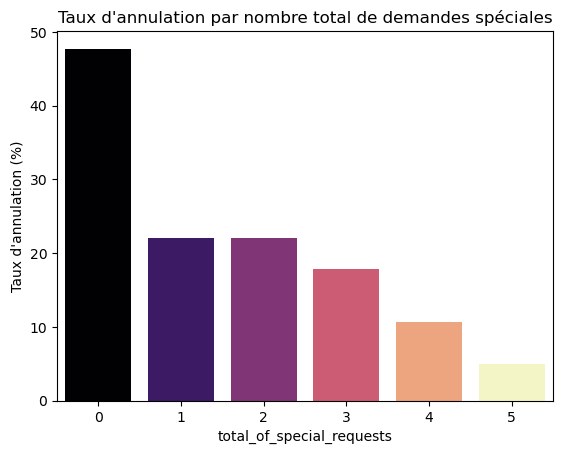

In [151]:
# Compter le nombre d'annulation par total_of_special_requests
total_of_special_requests_counts = hotel_df['total_of_special_requests'].value_counts().sort_index()
print("Nombre de personne par total_of_special_requests\n",total_of_special_requests_counts)
# Calcul du taux d'annulation par total_of_special_requests
cancelation_rate_total_of_special_requests = hotel_df.groupby('total_of_special_requests')['is_canceled'].mean() * 100
print("\nCancelation rate / total_of_special_requests\n",cancelation_rate_total_of_special_requests)

# Barplot des taux d'annulation par total_of_special_requests
sns.barplot(x=cancelation_rate_total_of_special_requests.index, y=cancelation_rate_total_of_special_requests.values, 
            hue=cancelation_rate_total_of_special_requests.index, palette='magma', legend=False)
plt.title("Taux d'annulation par nombre total de demandes spéciales")
plt.xlabel("total_of_special_requests")
plt.ylabel("Taux d'annulation (%)")

plt.show()

<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse des taux d'annulation par nombre de total_of_special_requests
    
Nous avons étudié l’impact du nombre total de demandes spéciales sur l’annulation des réservations.

**Répartition des réservations :**  
- `0` : 70 318 réservations  
- `1` : 33 226 réservations  
- `2` : 12 969 réservations  
- `3` : 2 497 réservations  
- `4` : 340 réservations  
- `5` : 40 réservations  

**Taux d’annulation selon le nombre de demandes spéciales :**  
- `0` : **47.72 %**  
- `1` : **22.02 %**  
- `2` : **22.09 %**  
- `3` : **17.86 %**  
- `4` : **10.58 %**  
- `5` : **5.00 %**  

**Interprétation :**  
- Il existe une **corrélation inverse forte** entre `total_of_special_requests` et `is_canceled` :  
  - **Plus le nombre de demandes spéciales est élevé, plus le taux d’annulation est faible.**  
  - Les clients avec `0` demandes spéciales ont un taux d’annulation **extrêmement élevé** (47.72 %).  
  - Dès `1 ou 2 demandes`, le taux d’annulation diminue significativement (~22 %).  
  - Pour `4 et 5 demandes`, le taux d’annulation est très bas, mais ces catégories contiennent très peu d’observations.  

**Prochaines étapes :**  
- Vérifier si **regrouper les catégories 4 et 5 en une seule (4+)** améliore la robustesse du modèle.  
- Tester l'impact de `total_of_special_requests` sur la performance des modèles avant toute transformation.  


.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Groupement des catégories 4 et 5 (4+) de total_of_special_requests


 total_of_special_requests_grouped
0    70318
1    33226
2    12969
3     2497
4      380
Name: count, dtype: int64 



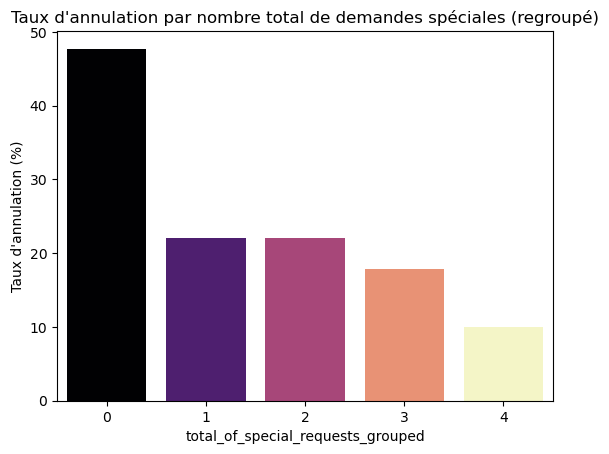


Corrélation total_of_special_requests vs is_canceled : -0.2347
Corrélation total_of_special_requests_grouped vs is_canceled : -0.2349



In [154]:
# Création d'une nouvelle variable avec regroupement des valeurs 4 et 5 en 4+
hotel_df["total_of_special_requests_grouped"] = hotel_df["total_of_special_requests"].apply(lambda x: x if x <= 3 else 4)
hotel_df["total_of_special_requests_grouped"] = hotel_df["total_of_special_requests_grouped"].astype("int64")

# Vérification de la répartition après transformation
print("\n",hotel_df["total_of_special_requests_grouped"].value_counts().sort_index(),"\n")


# Calcul du taux d'annulation après regroupement
cancelation_rate_grouped = hotel_df.groupby("total_of_special_requests_grouped")["is_canceled"].mean() * 100

# Barplot des taux d'annulation
sns.barplot(x=cancelation_rate_grouped.index, y=cancelation_rate_grouped.values, 
            hue=cancelation_rate_grouped.index, palette="magma", legend=False)
plt.title("Taux d'annulation par nombre total de demandes spéciales (regroupé)")
plt.xlabel("total_of_special_requests_grouped")
plt.ylabel("Taux d'annulation (%)")
plt.show()


# Calcul des corrélations
corr_original = hotel_df["total_of_special_requests"].corr(hotel_df["is_canceled"])
corr_grouped = hotel_df["total_of_special_requests_grouped"].corr(hotel_df["is_canceled"])

print(f"\nCorrélation total_of_special_requests vs is_canceled : {corr_original:.4f}")
print(f"Corrélation total_of_special_requests_grouped vs is_canceled : {corr_grouped:.4f}\n")

<p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse du groupement des catégories 4 et 5 (4+) de total_of_special_requests

**Pourquoi cette transformation ?**  
Les catégories `4` et `5` étaient très rares, ce qui pouvait introduire du bruit sans apporter d’information significative. Nous avons testé la fusion de ces catégories en une seule (`4+`) afin de simplifier la variable sans perte notable d'information.

**Répartition après transformation**  
`0` : 70 318 observations  
`1` : 33 226 observations  
`2` : 12 969 observations  
`3` : 2 497 observations  
`4+` : 380 observations  

**Comparaison des corrélations avec `is_canceled`**  
Avant transformation : `-0.2347`  
Après transformation : `-0.2349`  

**Interprétation**  
La corrélation reste pratiquement inchangée après la fusion des catégories `4` et `5`.  
Cela confirme que cette transformation ne fait pas perdre d’information significative.  
Les catégories `4` et `5` étaient trop rares pour influencer fortement `is_canceled`.  

**Conclusion**  
**La variable `total_of_special_requests_grouped` sera utilisée dans le modèle à la place de `total_of_special_requests`.**


### **5.1.2 Vérification des transformations des variables numériques**

.  

 <p style="background-color:Gold; color:black; font-weight:bold;text-align:center;">Coefficient de corrélation de Pearson et Heatmap de corrélation des variables numériques significatives

📊 Corrélations de Pearson entre is_canceled et les variables numériques significatives transformées :



,is_canceled
lead_time_log,0.320063
previous_cancellations_bin,0.270943
booking_changes_capped,-0.160848
required_car_parking_spaces_bin,-0.197399
total_of_special_requests_grouped,-0.234870


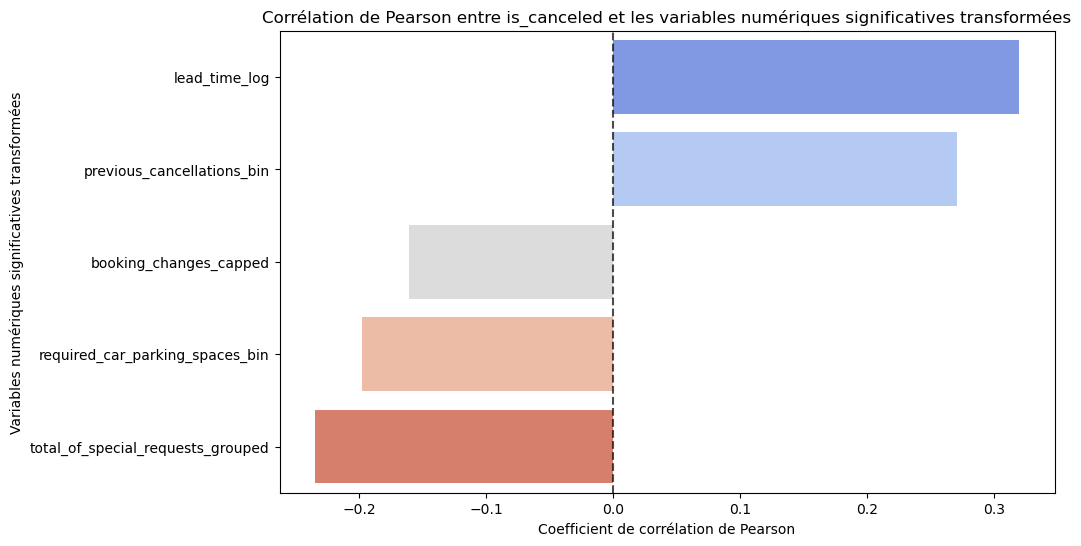

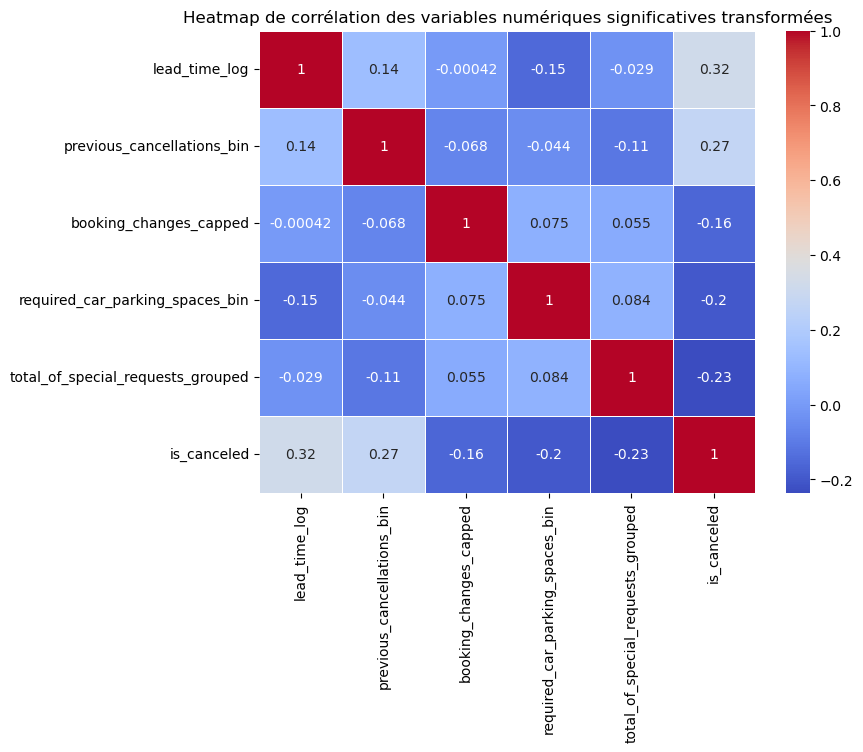

In [158]:
# Filtrer uniquement les variables numériques significatives transformées + is_canceled
modified_significativ_numeric_cols = hotel_df[['lead_time_log', 'previous_cancellations_bin', 'booking_changes_capped',
                                      'required_car_parking_spaces_bin','total_of_special_requests_grouped', 'is_canceled']]

# Calcul des corrélations de Pearson entre les vvariables numériques significatives transformées et is_canceled
correlation_matrix = modified_significativ_numeric_cols.corr()

# Sélection des corrélations avec is_canceled uniquement
correlation_with_target = correlation_matrix["is_canceled"].drop("is_canceled").sort_values(ascending=False)

# Affichage des corrélations sous forme de tableau
print("📊 Corrélations de Pearson entre is_canceled et les variables numériques significatives transformées :\n")
display(correlation_with_target.to_frame())

# Visualisation sous forme de barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, hue=correlation_with_target.index, palette="coolwarm")
plt.title("Corrélation de Pearson entre is_canceled et les variables numériques significatives transformées")
plt.xlabel("Coefficient de corrélation de Pearson")
plt.ylabel("Variables numériques significatives transformées")
plt.axvline(x=0, color='black', linestyle="--", alpha=0.7)  # Ligne verticale pour séparer valeurs positives et négatives
plt.show()

print('\n'*3)
      

# Filtrer uniquement les variables numériques significatives transformées (sans is_canceled)
modif_significativ_numeric_cols = hotel_df[['lead_time_log', 'previous_cancellations_bin', 'booking_changes_capped',
                                      'required_car_parking_spaces_bin','total_of_special_requests_grouped']]

# Calcul de la matrice de corrélation
plt.figure(figsize=(8,6))
sns.heatmap(modified_significativ_numeric_cols.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap de corrélation des variables numériques significatives transformées")
plt.show()

  <p style="background-color:LightGoldenRodYellow; color:black; font-weight:bold;text-align:center;">Analyse des corrélations finales des variables numériques significatives transformées  

Nous avons recalculé les corrélations entre `is_canceled` et les variables numériques après transformation.  

**Interprétation**  
- Les variables transformées conservent une bonne corrélation avec `is_canceled`, confirmant la pertinence des transformations.  
- `lead_time_log` reste la variable la plus corrélée avec les annulations (**0.32**), ce qui justifie pleinement son utilisation.  
- `previous_cancellations_bin` montre une relation forte avec `is_canceled`, validant la binarisation.  
- Les autres variables conservent une corrélation modérée, mais restent significatives, sans valeur aberrante ou redondance excessive.  


### **5.1.3 Suppression des anciennes colonnes numériques qui ont été transformées**

In [161]:
# Supprimer les anciennes colonnes du dataset
columns_to_drop = ['lead_time', 'previous_cancellations', 'booking_changes', 
                   'required_car_parking_spaces', 'total_of_special_requests']

hotel_df.drop(columns=columns_to_drop, inplace=True)

# Vérification : Afficher uniquement les colonnes numériques restantes
numeric_cols_remaining = hotel_df.select_dtypes(include=['int64', 'float64']).columns

print("Variables numériques restantes après suppression des anciennes colonnes :")
print(numeric_cols_remaining)


Variables numériques restantes après suppression des anciennes colonnes :
Index(['is_canceled', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_bookings_not_canceled', 'agent',
       'days_in_waiting_list', 'adr', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped'],
      dtype='object')


## **5.2 Préparation des Variables Catégorielles**

### **5.2.1 Application des transformations des variables catégorielles**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Suppression des variables catégorielles redondantes et inutiles

In [165]:
# Suppression des variables catégorielles redondantes et innutiles                                                    
columns_to_drop = ['market_segment', 'distribution_channel', 'country']                                    
hotel_df.drop(columns=columns_to_drop, inplace=True)
            
# Vérification des variables catégorielles restantes après transformation
categorical_cols_remaining = hotel_df.select_dtypes(include=['object']).columns
print("Variables catégorielles restantes après suppression des redondantes :")
print(categorical_cols_remaining)                                          

Variables catégorielles restantes après suppression des redondantes :
Index(['hotel', 'arrival_date_month', 'meal', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'customer_type',
       'reservation_status', 'country_grouped', 'reservation_status_month',
       'arrival_month_year'],
      dtype='object')


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application des transformations One-Hot-Encoding (OHE) des variables catégorielles

In [167]:
# Vérifier si 'country_grouped' existe avant d'appliquer One-Hot Encoding
if 'country_grouped' in hotel_df.columns:
    hotel_df = pd.get_dummies(hotel_df, columns=['country_grouped'], drop_first=True)

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
     Application des transformations Label Encoding des variables catégorielles

In [169]:
# Définir les mappings pour Label Encoding
label_mappings = {
    "hotel": {"City Hotel": 0, "Resort Hotel": 1},
    "meal": {"Undefined": 0, "HB": 1, "SC": 2, "BB": 3, "FB": 4},
    "deposit_type": {"Refundable": 0, "No Deposit": 1, "Non Refund": 2},
    "customer_type": {"Group": 0, "Transient-Party": 1, "Contract": 2, "Transient": 3}
}

# Appliquer l'encodage Label Encoding uniquement si la colonne contient encore des chaînes de caractères
for col, mapping in label_mappings.items():
    if col in hotel_df.columns:
        # Vérifier si la colonne contient encore des strings avant d'encoder
        if hotel_df[col].dtype == "object":
            hotel_df[col] = hotel_df[col].map(mapping)

### **5.2.2 Vérification des transformations des variables catégorielles**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Vérification One-Hot Encoding

In [172]:
encoded_columns = [col for col in hotel_df.columns if "country_grouped" in col]
print("Vérification après One-Hot Encoding :")
print(hotel_df[encoded_columns].head())        

Vérification après One-Hot Encoding :
   country_grouped_BEL  country_grouped_BRA  country_grouped_CHE  \
0                False                False                False   
1                False                False                False   
2                False                False                False   
3                False                False                False   
4                False                False                False   

   country_grouped_CHN  country_grouped_CN  country_grouped_DEU  \
0                False               False                False   
1                False               False                False   
2                False               False                False   
3                False               False                False   
4                False               False                False   

   country_grouped_ESP  country_grouped_FRA  country_grouped_GBR  \
0                False                False                False   
1             

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Vérifivation Label Encoding

In [174]:
print("Vérification après Label Encoding :")
print(hotel_df[["hotel", "meal", "deposit_type", "customer_type"]].head(20))
print(hotel_df[["hotel", "meal", "deposit_type", "customer_type"]].nunique())

Vérification après Label Encoding :
    hotel  meal  deposit_type  customer_type
0       1     3             1              3
1       1     3             1              3
2       1     3             1              3
3       1     3             1              3
4       1     3             1              3
5       1     3             1              3
6       1     3             1              3
7       1     4             1              3
8       1     3             1              3
9       1     1             1              3
10      1     3             1              3
11      1     1             1              3
12      1     3             1              3
13      1     1             1              3
14      1     3             1              3
15      1     3             1              3
16      1     3             1              2
17      1     3             1              3
18      1     3             1              3
19      1     3             1              3
hotel            2


### **5.2.3 Suppression des anciennes colonnes catégorielles transformées**

In [176]:
# Suppression de l'ancienne colonne country_grouped (remplacée par One-Hot Encoding)
if "country_grouped" in hotel_df.columns:
    hotel_df.drop(columns=["country_grouped"], inplace=True)

# Vérification que la colonne a bien été supprimée
print("Colonnes restantes après suppression :")
print(hotel_df.columns)

Colonnes restantes après suppression :
Index(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'reservation_status_date', 'arrival_datetime', 'room_change',
       'market_segment_encoded', 'distribution_channel_encoded',
       'reservation_status_month', 'arrival_month_year', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'country_grouped_BEL', 'country_grouped_BRA', 'country_grouped_CHE',
       'country_grouped_CHN', 'country_grouped_CN', 'country_grouped_DEU',
       'c

## **5.3 Préparation des Variables Datetime**

### **5.3.1 Application des transformations des variables datetime**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Filtrage des dates sur reservation_status_month

In [180]:
# Filtrer et modifier hotel_df en place
hotel_df = hotel_df.loc[(hotel_df['reservation_status_month'] >= '2015-07') & 
                        (hotel_df['reservation_status_month'] <= '2017-08')]

# Convertir reservation_status_month en entier (ex: '2016-09' → 201609)
hotel_df["reservation_status_month"] = hotel_df["reservation_status_month"].str.replace("-", "").astype(int)

# Vérification de la conversion
print("\nVérification après conversion de reservation_status_month :")
print(hotel_df["reservation_status_month"].head())
print("\nNouveau type de données :", hotel_df["reservation_status_month"].dtype)


Vérification après conversion de reservation_status_month :
0    201507
1    201507
2    201507
3    201507
4    201507
Name: reservation_status_month, dtype: int32

Nouveau type de données : int32


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Suppression de la colonne arrival_month_year.

In [182]:
# Supprimer la colonne arrival_month_year
if 'arrival_month_year' in hotel_df.columns:
    hotel_df.drop(columns=['arrival_month_year'], inplace=True)

### **5.3.2 Vérification des transformations des variables datetime**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Vérification du filtrage des dates sur reservation_status_month

In [185]:
# Vérification des valeurs uniques restantes après filtrage
print("Vérification des valeurs uniques de reservation_status_month après filtrage :")
print(hotel_df['reservation_status_month'].unique())

Vérification des valeurs uniques de reservation_status_month après filtrage :
[201507 201508 201509 201510 201511 201512 201601 201602 201603 201604
 201605 201606 201607 201608 201609 201610 201611 201612 201701 201702
 201703 201704 201705 201706 201707 201708]


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Vérification de la suppression de la colonne arrival_month_year.

In [187]:
# Vérifier que la colonne arrival_month_year a bien été supprimée
if 'arrival_month_year' in hotel_df.columns:
    print("ERREUR : arrival_month_year est toujours dans le dataset !")
else:
    print("Vérification OK : arrival_month_year a bien été supprimé.")

Vérification OK : arrival_month_year a bien été supprimé.


### **5.3.3 Suppression des anciennes colonnes datetime transformées**

In [189]:
# Liste des colonnes datetime à supprimer
cols_to_drop = ["reservation_status_date", "arrival_datetime"]

# Vérifier si les colonnes existent avant de les supprimer
hotel_df.drop(columns=[col for col in cols_to_drop if col in hotel_df.columns], inplace=True)

# Vérification après suppression
print("Colonnes restantes après suppression des anciennes variables datetime :")
print(hotel_df.columns)

Colonnes restantes après suppression des anciennes variables datetime :
Index(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'room_change', 'market_segment_encoded', 'distribution_channel_encoded',
       'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'country_grouped_BEL', 'country_grouped_BRA', 'country_grouped_CHE',
       'country_grouped_CHN', 'country_grouped_CN', 'country_grouped_DEU',
       'country_grouped_ESP', 'country_grouped_FRA',

## **5.4 Suppression des autres colonnes non significatives**

In [191]:
print(hotel_df.columns)

Index(['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr', 'reservation_status',
       'room_change', 'market_segment_encoded', 'distribution_channel_encoded',
       'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'country_grouped_BEL', 'country_grouped_BRA', 'country_grouped_CHE',
       'country_grouped_CHN', 'country_grouped_CN', 'country_grouped_DEU',
       'country_grouped_ESP', 'country_grouped_FRA', 'country_grouped_GBR',
       'country_grouped_IRL', 'country_grouped_I

In [192]:
# Définir les variables à conserver
variables_a_garder = ["is_canceled", "reservation_status_month",
    "lead_time_log", "previous_cancellations_bin", "booking_changes_capped",
    "required_car_parking_spaces_bin", "total_of_special_requests_grouped",
    "hotel", "meal", "deposit_type", "customer_type",'country_grouped_BEL', 
    'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN', 
    'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP', 
    'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
    'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD', 
    'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL', 
    'country_grouped_PRT', 'country_grouped_RUS','country_grouped_SWE', 
    'country_grouped_USA']

# Filtrer le DataFrame pour ne garder que ces variables
hotel_df = hotel_df[variables_a_garder]

# Vérification des colonnes restantes
print("Colonnes finales après suppression des variables non significatives :")
print(hotel_df.columns)


Colonnes finales après suppression des variables non significatives :
Index(['is_canceled', 'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'hotel', 'meal', 'deposit_type', 'customer_type', 'country_grouped_BEL',
       'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN',
       'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP',
       'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
       'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD',
       'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL',
       'country_grouped_PRT', 'country_grouped_RUS', 'country_grouped_SWE',
       'country_grouped_USA'],
      dtype='object')


## **5.5 Vérification finale et récapitulatif des variables clés**

In [194]:
# Vérification des colonnes finales
print("\nListe finale des colonnes dans le dataset :")
print(hotel_df.columns)

# Classification des variables restantes
variables_numeriques = ["lead_time_log", "previous_cancellations_bin", "booking_changes_capped",
                        "required_car_parking_spaces_bin", "total_of_special_requests_grouped"]

variables_categorielles = ["hotel", "meal", "deposit_type", "customer_type"] + [col for col in hotel_df.columns if "country_grouped_" in col]  

variables_datetime = ["reservation_status_month"] 

# Affichage des catégories de variables
print("\n\nVariables numériques :", variables_numeriques)
print("\n\n\nVariables catégorielles (encodées) :", variables_categorielles)
print("\n\n\nVariables datetime :", variables_datetime)

# Aperçu final du dataset après preprocessing
print("\n\n\nAperçu des informations du dataset :")
hotel_df.info()


Liste finale des colonnes dans le dataset :
Index(['is_canceled', 'reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'hotel', 'meal', 'deposit_type', 'customer_type', 'country_grouped_BEL',
       'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN',
       'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP',
       'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
       'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD',
       'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL',
       'country_grouped_PRT', 'country_grouped_RUS', 'country_grouped_SWE',
       'country_grouped_USA'],
      dtype='object')


Variables numériques : ['lead_time_log', 'previous_cancellations_bin', 'booking_changes_capped', 'required_car_parking_spaces_bin', 'total_of_special_req

# **6- Modélisation**

## **6.1  Séparation des données (train/test split)**

In [197]:
# Définition des features (X) et de la target (y)
X = hotel_df.drop(columns=['is_canceled'])  # On enlève la variable cible
y = hotel_df['is_canceled']  # Variable cible

# Découper en 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification des dimensions
print("Taille du dataset d'entraînement :", X_train.shape)
print("Taille du dataset de test :", X_test.shape)


Taille du dataset d'entraînement : (93317, 30)
Taille du dataset de test : (23330, 30)


## **6.2 Modélisation : Phase 1 - Baseline Models**
- ***Logistic Regression***
- ***K-Nearest Neighbors (KNN)*** 
- ***Decision Tree Classifier***

### **6.2.1 Entraînement des modèles baseline**

In [200]:
# Initialiser les modèles
log_reg = LogisticRegression(max_iter=5000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)  # Par défaut, K=5
decision_tree = DecisionTreeClassifier(random_state=42)

# Entraînement des modèles
log_reg.fit(X_train, y_train)
knn.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

# Stocker les modèles dans un dictionnaire pour faciliter l’évaluation
models = {
    "Logistic Regression": log_reg,
    "K-Nearest Neighbors": knn,
    "Decision Tree Classifier": decision_tree}

# Vérification des modèles entraînés
for model_name, model in models.items():
    print(f"{model_name} entraîné avec succès")

Logistic Regression entraîné avec succès
K-Nearest Neighbors entraîné avec succès
Decision Tree Classifier entraîné avec succès


### **6.2.2 Évaluation des modèles**

In [202]:
# Stocker les résultats
results = []

# Boucle sur chaque modèle entraîné
for model_name, model in models.items():
    # Prédictions sur les données de test
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe 1

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Stocker les résultats dans une liste
    results.append([model_name, accuracy, f1, auc_roc])

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results, columns=["Modèle", "Accuracy", "F1-Score", "AUC-ROC"])

# Trier par AUC-ROC décroissant
results_df = results_df.sort_values(by="AUC-ROC", ascending=False)

# Affichage du tableau des résultats
print("\nComparatif des modèles :")
print(results_df)



Comparatif des modèles :
                     Modèle  Accuracy  F1-Score   AUC-ROC
1       K-Nearest Neighbors  0.848350  0.780956  0.906310
0       Logistic Regression  0.795542  0.668474  0.858068
2  Decision Tree Classifier  0.845435  0.781719  0.838558


<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Explication des métriques d’évaluation  

**Accuracy (Taux de Prédictions Correctes)**  
L'**accuracy** mesure **le pourcentage de prédictions correctes** parmi toutes les prédictions faites.  

**Exemple concret :**  
Si un modèle prédit correctement **85 réservations sur 100**, son **accuracy est de 85 %**.  

**Attention :**  
Si **95 % des réservations sont confirmées et seulement 5 % sont annulées**, un modèle qui **prédit toujours "Confirmé"** aura **95 % d’accuracy**, **mais il n’a en réalité rien appris** sur les annulations.  
**C’est pourquoi il faut utiliser d'autres métriques en plus de l'accuracy.**  

---

**F1-Score (Équilibre entre Précision et Rappel)**  
L’**F1-Score** est une mesure qui **équilibre la précision et le rappel**.  
Il est particulièrement utile **si les classes sont déséquilibrées**. *(ex: 95 % de réservations confirmées et 5 % d'annulées)*  
  
**Précision (Precision) vs  Rappel (Recall)**    
**Précision (`Precision`)** : Parmi les réservations prédites comme annulées, combien étaient vraiment annulées ?    
**Rappel (`Recall`)** : Parmi toutes les vraies annulations, combien ont été bien détectées ?  
  
**Exemple concret :**  
Si un modèle prédit **10 annulations**, mais en réalité :  
- **7 d'entre elles sont effectivement annulées (TP)** 
- **3 d'entre elles sont fausses (FP) → elles ont été confirmées, mais mal prédites comme annulées**   
- **5 autres annulations n'ont pas été détectées par le modèle (FN)**   


**Le F1-score combine ces deux métriques pour donner une valeur équilibrée.**  

---

**AUC-ROC (Capacité à Distinguer les Classes)**  
L’**AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)** **mesure la capacité du modèle à bien séparer les classes (`is_canceled = 1` et `is_canceled = 0`)**.  

**Pourquoi c’est important ?**  
L’AUC-ROC ne dépend pas d’un seuil spécifique et permet de voir **si un modèle fait une bonne distinction entre annulations et non-annulations**.  

**Interprétation des valeurs de AUC-ROC :**  
- **AUC-ROC = 1** → Modèle parfait  
- **AUC-ROC = 0.5** → Modèle au hasard (aucune capacité à différencier les classes)  
- **AUC-ROC < 0.5** → Le modèle se trompe plus qu’il ne réussit  
- **Plus proche de 1, meilleur est le modèle**  

**Un AUC-ROC élevé indique que le modèle classe bien les réservations annulées et confirmées.**  

---

**Valeurs de références :**
| **Métrique**   | **Mauvais**  | **Moyen**     | **Bon**      | **Très bon**  | **Excellent** |
|---------------|------------|-------------|------------|--------------|--------------|
| **Accuracy**  | < 60 %      | 60 % - 70 %   | 70 % - 85 %  | 85 % - 95 %    | > 95 %        |
| **F1-Score**  | < 0.50     | 0.50 - 0.65 | 0.65 - 0.80 | 0.80 - 0.90  | > 0.90       |
| **AUC-ROC**   | < 0.60     | 0.60 - 0.75 | 0.75 - 0.85 | 0.85 - 0.95  | > 0.95       |

---

**Conclusion**  
- **Accuracy** seule n’est pas suffisante, surtout si les classes sont déséquilibrées.  
- **F1-Score** est un bon indicateur global, notamment quand il y a un risque d’erreurs sur une classe.  
- **AUC-ROC** est essentiel pour mesurer la capacité du modèle à bien séparer les annulations et les confirmations.  


### **6.2.3 Analyse des résultats et décision**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des résultats - Phase 1 (Baseline Models)  


**Observations :**  
**K-Nearest Neighbors (KNN) est le meilleur modèle sur cette phase avec :**  
- **Accuracy** = 84.8 % (le plus élevé)  
- **F1-Score** = 0.78 (équilibré entre précision et rappel)  
- **AUC-ROC** = 0.90 (très bon score, montre qu'il classe bien les annulations)  

**Decision Tree Classifier a des résultats similaires à KNN, avec une accuracy légèrement inférieure (84.5 %) mais un F1-score équivalent.**  
- Cependant, son **AUC-ROC est plus bas (0.83)**, ce qui signifie qu'il est moins bon pour différencier les annulations/non-annulations.  

**Logistic Regression est clairement le moins performant :**  
- **Accuracy** = 79.5 %  
- **F1-Score** = 0.66 (beaucoup plus bas que les autres modèles)  
- **AUC-ROC** = 0.85 (inférieur aux autres modèles)  

**Conclusion :**   
La relation entre les variables et l'annulation n'est pas linéaire, donc un modèle plus puissant est nécessaire.  


**Prochaine étape : Phase 2 - Ensemble Learning**  
Les résultats montrent que **les modèles plus avancés ont le potentiel d’améliorer la prédiction des annulations**.  
On va tester **Random Forest, Extra Trees, AdaBoost et Gradient Boosting** pour voir si on peut améliorer l’accuracy et l’AUC-ROC.  


## **6.3 Modélisation : Phase 2 - Ensemble Learning**
- ***Random Forest Classifier***
- ***Extra Trees Classifier***
- ***AdaBoost Classifier***
- ***Gradient Boosting Classifier***

### **6.3.1 Entraînement des modèles d’ensemble**

In [208]:
# Initialisation des modèles d’ensemble
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entraînement des modèles
random_forest.fit(X_train, y_train)
extra_trees.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Stocker les modèles dans un dictionnaire
ensemble_models = {"Random Forest": random_forest,
                   "Extra Trees": extra_trees,
                   "AdaBoost": adaboost,
                   "Gradient Boosting": gradient_boosting}

print("Entraînement des modèles d’ensemble terminé !")


Entraînement des modèles d’ensemble terminé !


### **6.3.2 Évaluation des modèles**

In [210]:
# Initialiser un dictionnaire pour stocker les résultats
results = []

# Évaluer chaque modèle
for name, model in ensemble_models.items():
    y_pred = model.predict(X_test)
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    # Stocker les résultats
    results.append({"Modèle": name, "Accuracy": accuracy, "F1-Score": f1, "AUC-ROC": auc_roc})

# Convertir en DataFrame pour affichage
results_df = pd.DataFrame(results).sort_values(by="AUC-ROC", ascending=False)

# Trier par AUC-ROC décroissant
results_df = results_df.sort_values(by="AUC-ROC", ascending=False)

# Affichage du tableau des résultats
print("\nComparatif des modèles :")
print(results_df)


Comparatif des modèles :
              Modèle  Accuracy  F1-Score   AUC-ROC
0      Random Forest  0.863480  0.801817  0.842764
1        Extra Trees  0.856537  0.792511  0.836008
3  Gradient Boosting  0.823360  0.721158  0.782208
2           AdaBoost  0.780840  0.613267  0.715550


### **6.3.3 Analyse des résultats et décision**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des résultats - Phase 2 (Ensemble Learning)  
</p>  

**Observations :**  
**Random Forest est le modèle le plus performant de cette phase avec :**  
- **Accuracy** = 86.3 % (le plus élevé dans cette phase)  
- **F1-Score** = 0.80 (équilibré entre précision et rappel)  
- **AUC-ROC** = 0.84 (bonne capacité de séparation entre annulations et non-annulations)  

**Extra Trees suit de près avec des performances très similaires à Random Forest.**  
- **Accuracy** = 85.6 %  
- **F1-Score** = 0.79  
- **AUC-ROC** = 0.83  

**Gradient Boosting et AdaBoost affichent des résultats plus faibles :**  
- **Gradient Boosting** : Accuracy de 82.3 % et AUC-ROC de 0.78, indiquant une performance moyenne.  
- **AdaBoost** : Nettement en dessous avec une accuracy de 78.0 % et un AUC-ROC de 0.71, ce qui le rend peu efficace sur ce dataset.  

**Comparaison avec les modèles baseline :**  
- **Les modèles d’ensemble n’apportent pas une amélioration significative par rapport à KNN et Decision Tree.**  
- **Random Forest et Extra Trees améliorent légèrement l’Accuracy et le F1-Score des modèles baseline, mais KNN obtient le meilleur AUC-ROC, ce qui indique une meilleure séparation des classes. Cependant, il est beaucoup plus lent et moins scalable que Random Forest et Extra Trees.**
- **Gradient Boosting et AdaBoost sont en dessous des modèles baseline, ce qui suggère qu'ils ne sont pas adaptés à ce dataset.**  

**Pourquoi ces résultats ?**  
- **Les modèles de Phase 1 capturent déjà bien la structure des données**, donc ajouter plus de complexité avec des modèles d’ensemble **n’apporte pas de gain significatif**.  
- **L’amélioration avec Random Forest et Extra Trees est modeste**, ce qui montre que l’agrégation d’arbres n’est pas nécessairement la meilleure approche sur ce dataset.  
- **Gradient Boosting et AdaBoost n’ont pas réussi à bien généraliser**, probablement à cause de leur sensibilité aux déséquilibres des classes et aux hyperparamètres standards.  

**Conclusion :**  
- **Les modèles d’ensemble testés ici ne surpassent pas clairement la baseline.**  
- **L’optimisation de ces modèles ne semble pas pertinente pour ce dataset.**  
- **Nous passons à la Phase 3 avec les modèles Boosting pour explorer d’autres approches plus avancées.**  


## **6.4 Modélisation : Phase 3 - Boosting & Deep Learning**
- ***Modèles Boosting :***  
    - ***XGBoost***  
    - ***CatBoost***  
    - ***LGBMClassifier***  
- ***Modèle Deep Learning :***  
    - ***Artificial Neural Network (ANN)*** (via TensorFlow/Keras)  

### **6.4.1 - Entraînement des modèles Boosting**

In [215]:
# Initialiser les modèles Boosting (avec suppression du warning pour XGBoost)
xgb = XGBClassifier(eval_metric="logloss", random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)  # verbose=0 pour éviter les logs
lgbm = LGBMClassifier(random_state=42)

# Entraînement des modèles
print("Entraînement de XGBoost...")
xgb.fit(X_train, y_train)

print("Entraînement de CatBoost...")
catboost.fit(X_train, y_train)

print("Entraînement de LGBM...")
lgbm.fit(X_train, y_train)

# Stocker les modèles dans un dictionnaire
boosting_models = {"XGBoost": xgb,
                   "CatBoost": catboost,
                   "LGBM": lgbm}

print("\nEntraînement des modèles Boosting terminé !")


Entraînement de XGBoost...
Entraînement de CatBoost...
Entraînement de LGBM...
[LightGBM] [Info] Number of positive: 33499, number of negative: 59818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 93317, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358981 -> initscore=-0.579791
[LightGBM] [Info] Start training from score -0.579791

Entraînement des modèles Boosting terminé !


### **6.4.2 Évaluation des modèles Boosting**

In [217]:
# Initialiser un dictionnaire pour stocker les résultats
boosting_results = []

# Boucle pour évaluer chaque modèle
for name, model in boosting_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    # Stocker les résultats
    boosting_results.append({"Modèle": name,
                             "Accuracy": round(accuracy, 6),
                             "F1-Score": round(f1, 6),
                             "AUC-ROC": round(auc_roc, 6)})

# Convertir en DataFrame pour affichage
boosting_results_df = pd.DataFrame(boosting_results)

# Trier par AUC-ROC décroissant
boosting_results_df = boosting_results_df.sort_values(by="AUC-ROC", ascending=False)

# Affichage du tableau des résultats
print("\nComparatif des modèles Boosting :")
print(boosting_results_df)


Comparatif des modèles Boosting :
     Modèle  Accuracy  F1-Score   AUC-ROC
1  CatBoost  0.858637  0.788128  0.830870
0   XGBoost  0.855551  0.784223  0.828200
2      LGBM  0.847878  0.770068  0.817461


### **6.4.3 Analyse des résultats Boosting**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des résultats - Phase 3 (Boosting Models)  
</p>

**Observations :**  

**CatBoost est le meilleur modèle de cette phase :**  
- **Accuracy** = 85.86 % (le plus élevé parmi les modèles Boosting).  
- **F1-Score** = 0.78 (équilibré entre précision et rappel).  
- **AUC-ROC** = 0.83 (meilleure capacité de séparation des classes).  

**XGBoost suit de très près avec des performances comparables :**  
- **Accuracy** = 85.55 %.  
- **F1-Score** = 0.78  
- **AUC-ROC** = 0.82  
- XGBoost est légèrement en dessous de CatBoost, mais reste un excellent modèle.  

**LGBM est un peu en retrait par rapport aux deux autres :**  
- **Accuracy** = 84.78 %.  
- **F1-Score** = 0.77  
- **AUC-ROC** = 0.81  
- Ce modèle est performant, mais semble moins efficace que CatBoost et XGBoost sur ces données.  


**Comparaison avec les phases précédentes :**
| **Phase**        | **Meilleur modèle**  | **Accuracy** | **F1-Score** | **AUC-ROC** |
|-----------------|---------------------|-------------|-------------|-------------|
| **Phase 1** (Baseline) | KNN               | 84.83 %       | 0.78        | 0.90       |
| **Phase 2** (Ensemble) | Random Forest     | 86.35 %       | 0.80        | 0.84       |
| **Phase 3** (Boosting) | CatBoost          | 85.86 %       | 0.78        | 0.83       |

.  
**Constat :**  
- **Les modèles Boosting ne surpassent pas les modèles de la phase 2** (Random Forest a la meilleure accuracy et AUC-ROC).  
- **CatBoost est légèrement en dessous de Random Forest, mais reste une bonne alternative.**  
- **LGBM est le moins performant des modèles Boosting.**  

.  
**Conclusion :**  
**Les modèles Boosting ne surpassent pas les méthodes d'Ensemble Learning comme Random Forest.**  
**CatBoost reste un modèle puissant, mais pas nécessairement meilleur que Random Forest.**  
**On pourrait envisager d'optimiser les paramètres des modèles d'ensemble afin d'observer si des améliorations sont possibles**

**Prochaine étape :**  
**Optimiser les paramètres des modèles d'ensemble avec RandomizedSearchCV pour observer si des améliorations sont possibles.**

### **6.4.4 Optimisation avec RandomizedSearchCV**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Optimisation XGBoost avec RandomizedSearchCV

In [222]:
# Définir l’espace des hyperparamètres
xgb_params = {"n_estimators": [100, 200, 300, 500],
              "max_depth": [3, 5, 10, 15],
              "learning_rate": [0.01, 0.05, 0.1, 0.2],
              "subsample": [0.6, 0.8, 1.0],
              "colsample_bytree": [0.6, 0.8, 1.0]}

# Configurer RandomizedSearchCV sur le modèle XGBoost déjà entraîné
xgb_random_search = RandomizedSearchCV(xgb,  # Utilisation du modèle déjà existant
                                       param_distributions=xgb_params, 
                                       n_iter=10,  # Nombre de combinaisons testées
                                       cv=3,  # Validation croisée à 3 folds
                                       scoring="roc_auc", 
                                       verbose=1, 
                                       random_state=42, 
                                       n_jobs=-1)

# Entraînement avec recherche des meilleurs hyperparamètres
xgb_random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour XGBoost :", xgb_random_search.best_params_)

# Évaluer le modèle optimisé
best_xgb = xgb_random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Calculer Accuracy, F1-score, AUC-ROC
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_roc_xgb = roc_auc_score(y_test, y_pred_xgb)

print(f"XGBoost optimisé - Accuracy: {accuracy_xgb:.4f}, F1-Score: {f1_xgb:.4f}, AUC-ROC: {auc_roc_xgb:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres pour XGBoost : {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
XGBoost optimisé - Accuracy: 0.8655, F1-Score: 0.8003, AUC-ROC: 0.8403


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Optimisation de CatBoost avec RandomizedSearchCV

In [224]:
# Définir l’espace des hyperparamètres pour CatBoost
catboost_params = {"iterations": [100, 300, 500],
                   "depth": [4, 6, 10],
                   "learning_rate": [0.01, 0.05, 0.1],
                   "l2_leaf_reg": [1, 3, 5, 7]}

# Configurer RandomizedSearchCV pour CatBoost
catboost_random_search = RandomizedSearchCV(catboost,  # Utilisation du modèle déjà existant
                                            param_distributions=catboost_params,
                                            n_iter=10,
                                            cv=3,
                                            scoring="roc_auc",
                                            verbose=1,
                                            random_state=42,
                                            n_jobs=-1)

# Entraînement avec recherche des meilleurs hyperparamètres
catboost_random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour CatBoost :", catboost_random_search.best_params_)

# Évaluer le modèle optimisé
best_catboost = catboost_random_search.best_estimator_
y_pred_catboost = best_catboost.predict(X_test)

# Calculer Accuracy, F1-score, AUC-ROC
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
auc_roc_catboost = roc_auc_score(y_test, y_pred_catboost)

print(f"CatBoost optimisé - Accuracy: {accuracy_catboost:.4f}, F1-Score: {f1_catboost:.4f}, AUC-ROC: {auc_roc_catboost:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres pour CatBoost : {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 10}
CatBoost optimisé - Accuracy: 0.8617, F1-Score: 0.7934, AUC-ROC: 0.8349


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Optimisation de LGBM avec RandomizedSearchCV

In [226]:
# Définir l’espace des hyperparamètres pour LGBM
lgbm_params = {"n_estimators": [100, 300, 500],
               "learning_rate": [0.01, 0.05, 0.1],
               "num_leaves": [20, 31, 40],
               "max_depth": [5, 10, 15]}

# Configurer RandomizedSearchCV pour LGBM
lgbm_random_search = RandomizedSearchCV(lgbm,  # Utilisation du modèle déjà existant
                                        param_distributions=lgbm_params,
                                        n_iter=10,
                                        cv=3,
                                        scoring="roc_auc",
                                        verbose=1,
                                        random_state=42,
                                        n_jobs=-1)

# Entraînement avec recherche des meilleurs hyperparamètres
lgbm_random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour LGBM :", lgbm_random_search.best_params_)

# Évaluer le modèle optimisé
best_lgbm = lgbm_random_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

# Calculer Accuracy, F1-score, AUC-ROC
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
auc_roc_lgbm = roc_auc_score(y_test, y_pred_lgbm)

print(f"LGBM optimisé - Accuracy: {accuracy_lgbm:.4f}, F1-Score: {f1_lgbm:.4f}, AUC-ROC: {auc_roc_lgbm:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 33499, number of negative: 59818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 93317, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358981 -> initscore=-0.579791
[LightGBM] [Info] Start training from score -0.579791
Meilleurs paramètres pour LGBM : {'num_leaves': 31, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}
LGBM optimisé - Accuracy: 0.8621, F1-Score: 0.7942, AUC-ROC: 0.8355


### **6.4.5 Analyse des résultats Boosting après optimisation**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Analyse des résultats - Phase 3 (Boosting après optimisation)  
</p>  

**Comparatif des résultats avant et après optimisation :**  

| **Modèle**  | **Accuracy (Avant)** | **F1-Score (Avant)** | **AUC-ROC (Avant)** | **Accuracy (Après)** | **F1-Score (Après)** | **AUC-ROC (Après)** |
|------------|------------------|------------------|------------------|------------------|------------------|------------------|
| **XGBoost**  | 85.55 %  | 0.7842  | 0.8282  | **86.55 %**  | **0.8003**  | **0.8403**  |
| **CatBoost**  | 85.86 %  | 0.7881  | 0.8308  | **86.17 %**  | **0.7934**  | **0.8349**  |
| **LGBM**  | 84.78 %  | 0.7700  | 0.8174  | **86.21 %**  | **0.7942**  | **0.8355**  |

.  
**Observations :**  
- **XGBoost est le modèle qui a le plus bénéficié de l’optimisation** :  
  - Gain d’**1 % en Accuracy** (85.55% → **86.55 %**).  
  - Amélioration du **F1-Score et de l’AUC-ROC**.  
  - L’optimisation a permis de mieux capturer les schémas des données.  

- **CatBoost et LGBM ont progressé également** :  
  - **CatBoost** : L’amélioration est plus légère, mais il reste performant.  
  - **LGBM** : Très bonne progression en F1-Score (+2.4 points), montrant une meilleure gestion du déséquilibre des classes.  

- **Le Boosting améliore la robustesse du modèle** :  
  - Tous les modèles ont gagné en stabilité après **ajustement des hyperparamètres**.  
  - L’augmentation du **nombre d’estimateurs et du max_depth** a permis une meilleure généralisation.  

**Conclusions :**  
- **L’optimisation des hyperparamètres a permis d’améliorer les performances des modèles Boosting.**  
- **XGBoost est le grand gagnant** avec les meilleures améliorations.  
- **CatBoost et LGBM restent des alternatives très solides.**  

.  
**Prochaine étape : Phase 4 - Deep Learning (ANN - Artificial Neural Network)**  

Maintenant que les modèles Boosting ont été optimisés, nous allons tester **un réseau de neurones artificiel (ANN)** pour voir s’il surpasse ces modèles en termes de performance.  

### **6.4.6 Test d’un modèle Deep Learning (ANN - Artificial Neural Network)**

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Préparation des données

In [231]:
# Standardisation des données pour l'ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification
print("Données normalisées pour ANN - Moyenne après scaling :", X_train_scaled.mean(axis=0))
print("Données normalisées pour ANN - Écart-type après scaling :", X_train_scaled.std(axis=0))

Données normalisées pour ANN - Moyenne après scaling : [-1.76667527e-13 -1.63707243e-17 -2.28428712e-17  2.39088718e-17
 -8.45566947e-17 -5.10157456e-17  6.68534696e-17 -1.84570399e-16
 -1.33326225e-16  1.99189836e-16 -2.70307309e-17  6.62443263e-17
  6.07620373e-17 -1.00508633e-17  3.31983061e-17 -3.95181671e-17
 -7.32494735e-17  2.17768705e-17 -3.04190901e-17 -5.13203172e-17
 -1.99494408e-17  1.46575090e-17 -1.43148659e-17 -7.38586167e-18
 -7.43154741e-17 -2.97338039e-17  4.59903139e-17  6.12188947e-17
  3.88328810e-18  3.16754480e-17]
Données normalisées pour ANN - Écart-type après scaling : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Construction du modèle ANN

In [233]:
# Définir l’architecture du modèle avec Input()
model = Sequential([
    keras.Input(shape=(X_train.shape[1],)),  # Définition explicite de l'entrée
    Dense(64, activation='relu'),  # Première couche cachée
    Dropout(0.3),  # Dropout pour éviter l'overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Couche de sortie (sigmoïde pour classification binaire)
])

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Afficher l’architecture du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Entraînement du modèle

In [235]:
# Entraînement du modèle
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=20, batch_size=32, verbose=1)

Epoch 1/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 936us/step - accuracy: 0.7704 - loss: 0.4674 - val_accuracy: 0.8098 - val_loss: 0.3905
Epoch 2/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 954us/step - accuracy: 0.8092 - loss: 0.3956 - val_accuracy: 0.8137 - val_loss: 0.3821
Epoch 3/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step - accuracy: 0.8154 - loss: 0.3861 - val_accuracy: 0.8158 - val_loss: 0.3799
Epoch 4/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 957us/step - accuracy: 0.8157 - loss: 0.3840 - val_accuracy: 0.8176 - val_loss: 0.3766
Epoch 5/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 938us/step - accuracy: 0.8174 - loss: 0.3802 - val_accuracy: 0.8185 - val_loss: 0.3743
Epoch 6/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 965us/step - accuracy: 0.8192 - loss: 0.3767 - val_accuracy: 0.8183 - val_loss: 0.3740
Epoch 7/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.8195 - loss: 0.3760 - val_accuracy: 0.8193 - val_loss: 0.3734
Epoch 8/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 3s 952us/step - accuracy: 0.8199 -

.  
 <p style="background-color:purple; color:white; font-weight:bold;text-align:center;">
Évaluation des performances

In [237]:
# Prédictions sur le test set
y_pred_ann = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calcul des scores
accuracy_ann = accuracy_score(y_test, y_pred_ann)
f1_ann = f1_score(y_test, y_pred_ann)
auc_roc_ann = roc_auc_score(y_test, y_pred_ann)

print(f"ANN - Accuracy: {accuracy_ann:.4f}, F1-Score: {f1_ann:.4f}, AUC-ROC: {auc_roc_ann:.4f}")

730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
ANN - Accuracy: 0.8231, F1-Score: 0.7232, AUC-ROC: 0.7836


<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Évaluation des performances du modèle ANN  
</p>

**Résultats sur le test set :**  
- **Accuracy** : 82.29 %  
- **F1-Score** : 0.7210  
- **AUC-ROC** : 0.7821  

**Comparaison avec les autres modèles :**  
- **L’ANN ne surpasse aucun des modèles Boosting ou d’Ensemble Learning.**  
- Il est **nettement inférieur à KNN en AUC-ROC (0.782 vs 0.906)**, ce qui signifie qu’il est moins performant pour différencier les annulations et non-annulations.  
- Il est **inférieur à Random Forest (AUC-ROC 0.842), XGBoost optimisé (AUC-ROC 0.840)** et CatBoost (AUC-ROC 0.834).  
- Ses performances sont **proches de Gradient Boosting (AUC-ROC 0.782)**, ce qui indique qu’il n’a pas su tirer parti des relations complexes dans les données.  

**Pourquoi ces résultats ?**  
- Contrairement aux modèles Boosting, l’ANN ne bénéficie pas des mécanismes de sélection de features comme l’importance des variables.  
- Il est possible que **les features disponibles ne nécessitent pas un modèle aussi complexe qu’un réseau de neurones**.  
- Les modèles Boosting, bien plus légers et optimisés pour ce type de problème, obtiennent de meilleurs résultats avec moins de ressources.  

**Améliorations possibles :**  
- **Augmenter la complexité du réseau** (plus de couches, plus de neurones)  
- **Ajuster le learning rate** pour une meilleure convergence  
- **Tester d’autres architectures plus profondes (RNN, LSTM si le temps est une variable clé)**  

**Conclusion :**  
L’ANN **n’apporte pas de valeur ajoutée significative** par rapport aux modèles Boosting. Sur ce dataset, **XGBoost et Random Forest restent les meilleurs choix** en raison de leur performance en accuracy, F1-score et AUC-ROC, tout en étant plus rapides et plus explicables.  

## **6.5 Comparaison finale et choix du meilleur modèle**

<p style="background-color:LightSteelBlue;color:black; font-weight:bold; font-size:18px;text-align:center;">  
Comparatif final des modèles & Conclusion  
</p>  

**Comparatif des modèles :**  

| **Modèle** | **Accuracy** | **F1-Score** | **AUC-ROC** | **Commentaires** |
|----------------------------|-------------|-------------|-------------|-----------------|
| **K-Nearest Neighbors (Phase 1 - Baseline)** | **84.83 %** | **0.7809** | **0.9063** | Très bon AUC-ROC, mais coûteux en calcul |
| **Decision Tree Classifier (Phase 1 - Baseline)** | 84.54 % | 0.7817 | 0.8386 | Performant, mais sujet à l’overfitting |
| **Logistic Regression (Phase 1 - Baseline)** | 79.55 % | 0.6685 | 0.8581 | Moins performant, limité par sa linéarité |
| **Random Forest (Phase 2 - Ensemble Learning)** | **86.35 %** | **0.8018** | **0.8428** | Meilleur modèle en phase 2, stable et robuste |
| **Extra Trees (Phase 2 - Ensemble Learning)** | 85.65 % | 0.7925 | 0.8360 | Similaire à Random Forest, légèrement moins performant |
| **Gradient Boosting (Phase 2 - Ensemble Learning)** | 82.34 % | 0.7212 | 0.7822 | Moins efficace, plus lent à entraîner |
| **AdaBoost (Phase 2 - Ensemble Learning)** | 78.08 % | 0.6133 | 0.7156 | Significativement moins bon que les autres modèles |
| **XGBoost (Phase 3 - Boosting, optimisé)** | **86.55 %** | **0.8003** | **0.8403** | Très bon équilibre entre performance et rapidité |
| **CatBoost (Phase 3 - Boosting, optimisé)** | 86.17 % | 0.7934 | 0.8349 | Comparable à XGBoost mais légèrement inférieur |
| **LGBM (Phase 3 - Boosting, optimisé)** | 86.21 % | 0.7942 | 0.8355 | Très proche de CatBoost, performant et rapide |
| **Artificial Neural Network (Phase 3 - Deep Learning)** | 82.29 % | 0.7210 | 0.7821 | Moins performant que les modèles Boosting |

.  
**Analyse finale des performances**  

1. **Phase 1 - Baseline Models**  
   - **K-Nearest Neighbors (KNN)** a montré la meilleure capacité à différencier les annulations et non-annulations (**AUC-ROC = 0.9063**).  
   - **Decision Tree** a obtenu de bons résultats, mais peut souffrir d’**overfitting**.  
   - **Logistic Regression** est le moins performant, confirmant que les relations entre variables ne sont pas purement linéaires.  

2. **Phase 2 - Ensemble Learning**  
   - **Random Forest** et **Extra Trees** ont surpassé les modèles baseline en accuracy et F1-score.  
   - **AdaBoost** est significativement moins efficace que les autres modèles d’ensemble.  

3. **Phase 3 - Boosting & Deep Learning**  
   - **XGBoost optimisé** est **le meilleur modèle** avec **Accuracy = 86.55 %** et **F1-score = 0.8003**.  
   - **CatBoost et LGBM** sont très proches, mais légèrement inférieurs.  
   - **Le réseau de neurones (ANN)** a des performances moindres que les modèles Boosting, ce qui montre que des méthodes plus simples suffisent pour ce problème.  

.  
**Pourquoi choisir XGBoost plutôt que KNN ?**  

| Critère | KNN | XGBoost | Avantage |
|---------|-----|---------|----------|
| **AUC-ROC** | **0.9063** | **0.8403** | KNN a un léger avantage |
| **Temps d’inférence** | Très lent | Très rapide | XGBoost est bien plus rapide |
| **Robustesse aux features inutiles** | Mauvaise | Excellente | XGBoost est plus stable |
| **Explicabilité** | Très faible | Bonne via feature importance | XGBoost est plus interprétable |
| **Overfitting / Généralisation** | Sensible au choix de `k` | Régularisation intégrée | XGBoost est plus fiable |

.  
**Conclusion**  
<p style="background-color:lightgreen; color:black; font-weight:bold;">XGBoost optimisé est le modèle final recommandé

Il offre un **meilleur compromis** entre précision, robustesse et rapidité.  

-    Bien que **KNN ait le meilleur AUC-ROC**, son temps d'inférence le rend **impraticable pour un déploiement en production**. **XGBoost est ainsi le meilleur compromis** entre performance et rapidité.
- **Les modèles Boosting surpassent les réseaux de neurones** pour ce problème spécifique, justifiant leur choix final.  

**Rappel des performances du modèle choisi :**
| **Modèle**  | **Accuracy** | **F1-Score** | **AUC-ROC** |
|------------|------------------|------------------|------------------|
| **XGBoost**  | **86.55 %**  | **0.8003**  | **0.8403**  |

# **7 - Sauvegarde du modèle final et export des prédictions**

### **6.6.1 Sauvegarde du modèle**

In [243]:
# Sauvegarde du modèle XGBoost optimisé
joblib.dump(best_xgb, "xgboost_final_model.pkl")

# Sauvegarde des noms des features utilisées (important pour future réutilisation)
joblib.dump(X_train.columns, "features.pkl")

print("Modèle XGBoost et features sauvegardés avec succès !")

Modèle XGBoost et features sauvegardés avec succès !


### **6.6.2 Génération et export des prédictions**

In [245]:
# Générer les prédictions sur le jeu de test
y_pred_test = best_xgb.predict(X_test)

# Créer un DataFrame pour stocker les résultats
predictions_df = pd.DataFrame({"Actual": y_test.values,
                               "Predicted": y_pred_test})

# Exporter les prédictions au format CSV
predictions_df.to_csv("predictions_xgboost.csv", index=False)

print("Prédictions générées et exportées avec succès !")

Prédictions générées et exportées avec succès !


In [246]:
# Vérifier le modèle
try:
    loaded_model = joblib.load("xgboost_final_model.pkl")
    print("Modèle XGBoost chargé avec succès !")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")

# Vérifier les features sauvegardées
try:
    loaded_features = joblib.load("features.pkl")
    print("Features chargées avec succès !")
    print("Liste des features sauvegardées :", loaded_features)
except Exception as e:
    print(f"Erreur lors du chargement des features : {e}")

# Vérifier le fichier des prédictions
try:
    loaded_predictions = pd.read_csv("predictions_xgboost.csv")
    print("Fichier des prédictions chargé avec succès !")
    print("Aperçu des 5 premières lignes :")
    print(loaded_predictions.head())
except Exception as e:
    print(f"Erreur lors du chargement des prédictions : {e}")


Modèle XGBoost chargé avec succès !
Features chargées avec succès !
Liste des features sauvegardées : Index(['reservation_status_month', 'lead_time_log',
       'previous_cancellations_bin', 'booking_changes_capped',
       'required_car_parking_spaces_bin', 'total_of_special_requests_grouped',
       'hotel', 'meal', 'deposit_type', 'customer_type', 'country_grouped_BEL',
       'country_grouped_BRA', 'country_grouped_CHE', 'country_grouped_CHN',
       'country_grouped_CN', 'country_grouped_DEU', 'country_grouped_ESP',
       'country_grouped_FRA', 'country_grouped_GBR', 'country_grouped_IRL',
       'country_grouped_ISR', 'country_grouped_ITA', 'country_grouped_NLD',
       'country_grouped_NOR', 'country_grouped_Others', 'country_grouped_POL',
       'country_grouped_PRT', 'country_grouped_RUS', 'country_grouped_SWE',
       'country_grouped_USA'],
      dtype='object')
Fichier des prédictions chargé avec succès !
Aperçu des 5 premières lignes :
   Actual  Predicted
0       0      